<a href="https://colab.research.google.com/github/brenoakihiromorimoto/portf-lio/blob/main/tera/desafio_luizalabs/Desafio_Luizalabs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As colunas dessa tabela estão descritas a seguir.

As colunas de ID de entidade são:
- `order_id`: identificador da venda; pode estar repetida em outras linhas, pois **cada linha corresponde à compra de um produto por um cliente**, que pode ter comprado outros produtos no mesmo evento.
- `client_id`: identificador do cliente que realizou a compra
- `datetime`: data e hora da compra
- `units`: quantidade de unidades do produto que foram comprados nesse evento de compra
- `price`: preço unitário do produto comprado
- `payment_method`: forma de pagamento (crétido, débito, _voucher_, etc) da compra
- `installments`: número de parcelas do pagamento; se estiver vazio, pode-se considerar que não se aplica
- `delivery_days`: prazo de entrega do produto
- `delivery_state`: estado onde ocorreu a entrega do produto; corresponde exatamente ao estado nas tabelas de cliente
- `device`: meio por onde  o cliente comprou; e.g. site, aplicativo do celular, terminal de compras
- `source`: canal de _marketing_ que gerou o _lead_ e ocasionou ao cliente comprar; por exemplo, pode ser um link em uma página parceira onde o cliente viu uma promoção

# Importar bibliotecas


In [31]:
import pandas as pd
import numpy as np
!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
import seaborn as sns
!pip install shap
import shap
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score

from scipy.stats import ttest_ind

from scipy.stats import chi2_contingency

from sklearn.impute import SimpleImputer

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

!pip install yellowbricks
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.classifier import ROCAUC

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

from prettytable import PrettyTable

from mlxtend.plotting import plot_learning_curves

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from yellowbrick.classifier import DiscriminationThreshold


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
ERROR: Could not find a version that satisfies the requirement yellowbricks (from versions: none)
ERROR: No matching distribution found for yellowbricks


# Importar Dataset

In [182]:
link = '/gdrive/MyDrive/Colab Notebooks/Tera/Luizalabs/'

# Datasets dos clientes.
client_train = pd.read_csv(link+'client.train.csv')
client_test = pd.read_csv(link+'client.test.csv')
client_desafio = pd.read_csv(link+'client.challenge.data.csv')

# Dataset de ordem.
orders = pd.read_csv(link+'orders.csv')

# Dataset de produto.
produto = pd.read_csv(link+'product.csv')

# Funções

In [33]:
def frequência(X_train, client_train):  
  frequência = X_train[['datetime', 'client_id']].groupby('client_id').agg(lambda x: x.value_counts())
  # Explodir o datetime em múltiplas colunas
  frequência = frequência['datetime'].apply(pd.Series)
  df_frequência = frequência.fillna(0.0)
  df_frequência = df_frequência.iloc[:, :].sum(axis=1)
  #df_frequência.rename(columns={0: 'frequência'}, inplace=True)
  df_frequência = df_frequência.reset_index()
  #df_frequência
  df_EDA_frequência = pd.merge(client_train, df_frequência, how='left', on='client_id')
  df_EDA_frequência.rename(columns={0:'frequência'}, inplace=True)
  return df_EDA_frequência

def recência(X_train, client_train):  
  recência = X_train[['datetime', 'client_id']]
  recência['datetime'] = pd.to_datetime(recência['datetime'])
  recência['ano'] = pd.DatetimeIndex(recência['datetime']).year
  recência['mês'] = pd.DatetimeIndex(recência['datetime']).month
  recência = recência[['mês', 'client_id']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_recência = recência['mês'].apply(pd.Series)
  df_recência = df_recência.iloc[:, :].max(axis=1)
  df_recência = df_recência-12
  df_recência = df_recência.reset_index()
  df_EDA_recência = pd.merge(df_recência, 
                            client_train[['client_id', 'is_churn']], 
                            how='right', 
                            on='client_id')
  df_EDA_recência.rename(columns={0:'recência'}, inplace=True)
  return df_EDA_recência 

def valor_monetário(X_train, client_train):  
  valor_monetário = X_train[['price', 'client_id']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_valor_monetário = valor_monetário['price'].apply(pd.Series)
  df_valor_monetário = df_valor_monetário.iloc[:, :].mean(axis=1)
  df_EDA_valor_monetário = pd.merge(pd.DataFrame(df_valor_monetário).reset_index(), 
                                    client_train[['client_id', 'is_churn']], how='right', on='client_id')
  df_EDA_valor_monetário.rename(columns={0: 'valor_monetário'}, inplace=True)
  return df_EDA_valor_monetário

def variância_parcelas(df_EDA_client_segment, client_train):
  df_EDA_client_installments = pd.merge(df_EDA_client_segment, orders, how='inner', on='client_id')
  df_EDA_client_installments = df_EDA_client_installments[['client_id', 'installments']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_EDA_client_installments = df_EDA_client_installments.installments.apply(pd.Series)
  df_EDA_client_installments = df_EDA_client_installments.iloc[:, :].std(axis=1)**2
  df_EDA_client_installments = pd.DataFrame(df_EDA_client_installments).reset_index()
  df_EDA_client_installments = df_EDA_client_installments.rename(columns={0: 'Variância das parcelas'})
  df_EDA_client_installments = pd.merge(df_EDA_client_installments, client_train, how='inner', on='client_id')
  return df_EDA_client_installments

def Soma_dias_delivery(df_EDA_soma_delivery_days, client_train):
  df_EDA_soma_delivery_days = pd.merge(df_EDA_soma_delivery_days, orders, how='inner', on='client_id')
  df_EDA_soma_delivery_days = df_EDA_soma_delivery_days[['client_id', 'delivery_days']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_EDA_soma_delivery_days = df_EDA_soma_delivery_days['delivery_days'].apply(pd.Series)
  df_EDA_soma_delivery_days = df_EDA_soma_delivery_days.iloc[:, :].sum(axis=1)
  df_EDA_soma_delivery_days = pd.DataFrame(df_EDA_soma_delivery_days).reset_index()
  df_EDA_soma_delivery_days = df_EDA_soma_delivery_days.rename(columns={0: 'Soma_dias_delivery'})
  df_EDA_soma_delivery_days = pd.merge(df_EDA_soma_delivery_days, client_train, how='inner', on='client_id')
  return df_EDA_soma_delivery_days

def dispositivo(df_EDA_dispositivo, client_train):
  df_EDA_soma_dispositivo = pd.merge(df_EDA_dispositivo, orders, how='inner', on='client_id')
  df_EDA_soma_dispositivo = df_EDA_soma_dispositivo[['client_id', 'device']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_EDA_soma_dispositivo = df_EDA_soma_dispositivo['device'].apply(pd.Series)
  for i in df_EDA_soma_dispositivo:
    df_EDA_soma_dispositivo[i] = LabelEncoder().fit_transform(df_EDA_soma_dispositivo[i])
  df_EDA_soma_dispositivo = df_EDA_soma_dispositivo.iloc[:, :].sum(axis=1)
  df_EDA_soma_dispositivo = pd.DataFrame(df_EDA_soma_dispositivo).reset_index()
  df_EDA_soma_dispositivo = df_EDA_soma_dispositivo.rename(columns={0: 'Soma_dispositivos'})
  df_EDA_soma_dispositivo = pd.merge(df_EDA_soma_dispositivo, client_train, how='inner', on='client_id')
  return df_EDA_soma_dispositivo

def payment(df_EDA_payment, client_train):
  df_EDA_payment_cat = pd.merge(df_EDA_payment, orders, how='inner', on='client_id')
  df_EDA_payment_cat = df_EDA_payment_cat[['client_id', 'payment_method']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_EDA_payment_cat = df_EDA_payment_cat['payment_method'].apply(pd.Series)
  for i in df_EDA_payment_cat:
    df_EDA_payment_cat[i] = LabelEncoder().fit_transform(df_EDA_payment_cat[i])
  df_EDA_payment_cat = df_EDA_payment_cat.iloc[:, :].std(axis=1)
  df_EDA_payment_cat = pd.DataFrame(df_EDA_payment_cat).reset_index()
  df_EDA_payment_cat = df_EDA_payment_cat.rename(columns={0: 'Desvio_padrão_pagamento'})
  df_EDA_payment_cat = pd.merge(df_EDA_payment_cat, client_train, how='inner', on='client_id')
  return df_EDA_payment_cat

# EDA 01

## Clientes

In [34]:
client_train.head(3)

,client_id,birthdate,state,gender,is_churn
0,cx05072,1972-03-22,st25,cg2,False
1,cx03836,1966-08-14,st15,cg1,False
2,cx08472,1954-08-07,st15,cg1,False


In [35]:
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23292 entries, 0 to 23291
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  23292 non-null  object
 1   birthdate  23292 non-null  object
 2   state      23292 non-null  object
 3   gender     23292 non-null  object
 4   is_churn   23292 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 750.7+ KB


In [36]:
client_train.describe()

,client_id,birthdate,state,gender,is_churn
count,23292,23292,23292,23292,23292
unique,23292,13046,27,2,2
top,cx05072,1990-01-01,st15,cg1,False
freq,1,58,8201,12879,19085


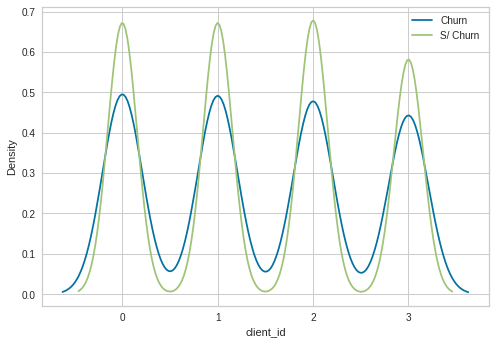

In [37]:
ax = sns.kdeplot(client_train[client_train['is_churn']==True]['client_id'].str[2].astype(int))
ax = sns.kdeplot(client_train[client_train['is_churn']==False]['client_id'].str[2].astype(int))
plt.legend(labels=["Churn","S/ Churn"])

* O código do cliente não parece ter relação com o churn.

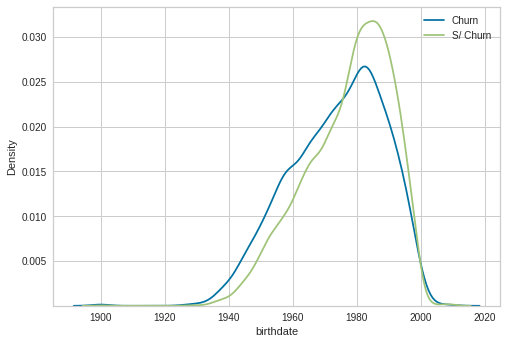

In [38]:
ax = sns.kdeplot(client_train[client_train['is_churn']==True]['birthdate'].str[:4].astype(int))
ax = sns.kdeplot(client_train[client_train['is_churn']==False]['birthdate'].str[:4].astype(int))
plt.legend(labels=["Churn","S/ Churn"])

* O ano que o cliente nasceu também não apresenta diferença entre as distribuições.
* Ambos apresentam uma concentração de pessoas nascidas em 1980.

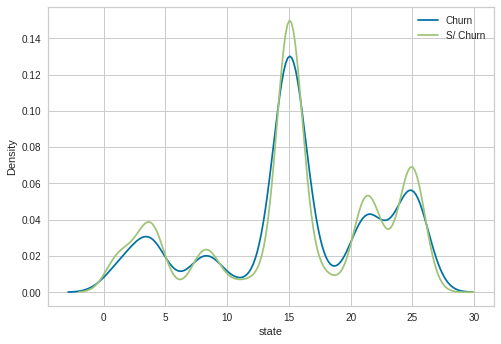

In [39]:
ax = sns.kdeplot(client_train[client_train['is_churn']==True]['state'].str[2:].astype(int))
ax = sns.kdeplot(client_train[client_train['is_churn']==False]['state'].str[2:].astype(int))
plt.legend(labels=["Churn","S/ Churn"])

* Muitos clientes são do estado 15.

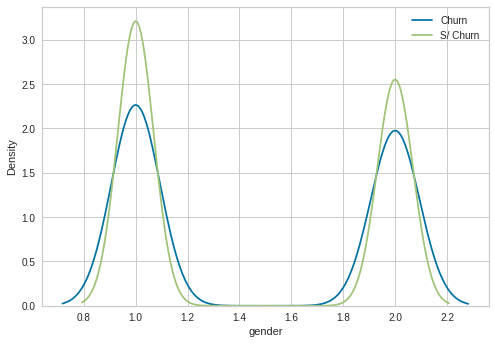

In [40]:
ax = sns.kdeplot(client_train[client_train['is_churn']==True]['gender'].str[2:].astype(int))
ax = sns.kdeplot(client_train[client_train['is_churn']==False]['gender'].str[2:].astype(int))
plt.legend(labels=["Churn","S/ Churn"])

* Sem diferenças significativas entre gêneros diferentes.

## Produtos

In [41]:
produto.head(3)

,product_id,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,px01237,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:04846
1,px11510,mk38,mk38:072,mk38:072:149,mk38:072:149:218,mk38:072:149:218:01337
2,px03782,mk38,mk38:072,mk38:072:019,mk38:072:019:066,mk38:072:019:066:02321


In [42]:
produto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12659 entries, 0 to 12658
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    12659 non-null  object
 1   category_lv0  12659 non-null  object
 2   category_lv1  12659 non-null  object
 3   category_lv2  12659 non-null  object
 4   category_lv3  12659 non-null  object
 5   category_lv4  12659 non-null  object
dtypes: object(6)
memory usage: 593.5+ KB


## Ordens

In [43]:
orders.head(3)

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08
1,ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08
2,ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08


## Clientes + Ordens + Produto

In [44]:
tabela_full = pd.merge(orders, client_train, how='inner', on='client_id')
tabela_full = pd.merge(tabela_full, produto, how='inner', on='product_id')

In [45]:
tabela_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101005 entries, 0 to 101004
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        101005 non-null  object 
 1   client_id       101005 non-null  object 
 2   product_id      101005 non-null  object 
 3   datetime        101005 non-null  object 
 4   units           101005 non-null  float64
 5   price           101005 non-null  float64
 6   payment_method  101005 non-null  object 
 7   installments    21991 non-null   float64
 8   delivery_days   53813 non-null   float64
 9   delivery_state  101005 non-null  object 
 10  device          101005 non-null  object 
 11  source          101005 non-null  object 
 12  birthdate       101005 non-null  object 
 13  state           101005 non-null  object 
 14  gender          101005 non-null  object 
 15  is_churn        101005 non-null  bool   
 16  category_lv0    101005 non-null  object 
 17  category_l

In [46]:
tabela_full.describe()

,units,price,installments,delivery_days
count,101005.000000,101005.000000,21991.000000,53813.000000
mean,1.228586,447.517332,4.531990,6.916656
std,1.564544,855.590526,4.694589,6.779945
min,0.000100,-8999.000000,1.000000,0.000000
25%,1.000000,39.900000,1.000000,2.000000
50%,1.000000,163.010000,3.000000,5.000000
75%,1.000000,699.000000,7.000000,9.000000
max,110.000000,25648.900000,24.000000,165.000000


### Variáveis Categóricas

In [47]:
var_categorica = [col for col in tabela_full if tabela_full[col].dtype in ['object', 'str', 'bool']]
tabela_full_categoria = tabela_full[var_categorica]

In [48]:
from sklearn.preprocessing import LabelEncoder

In [49]:
for var in var_categorica:
  tabela_full_categoria[var] =  LabelEncoder().fit_transform(tabela_full_categoria[var])

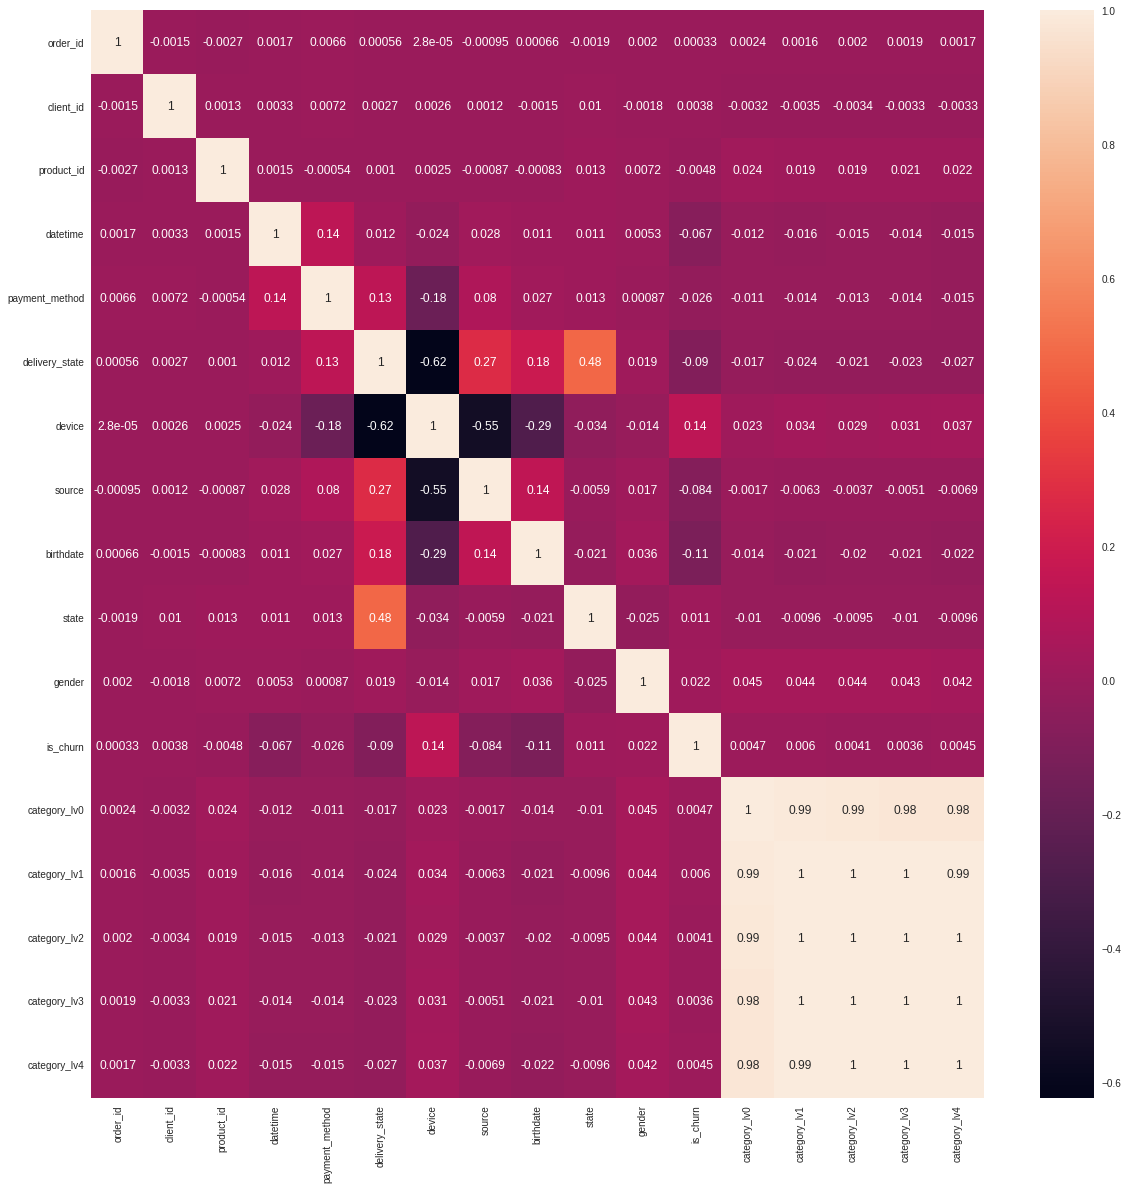

In [50]:
plt.figure(figsize=(20, 20))
sns.heatmap(tabela_full_categoria.corr(), annot=True)

* Pela matriz de correlação de Pearson, algumas variáveis estão levemente correlacionadas com o churn:
  * device
  * source
  * birthdate
  * delivery_state
  * Datetime

* Investigar variáveis com correlação moderada em relação à delivery_state:
  * state
  * device

* Investigar variáveis com correlação moderada em relação à source:
  * device

### Variáveis Numéricas

In [51]:
var_numerica = [col for col in tabela_full if tabela_full[col].dtype in ['int64', 'float64']]
tabela_full_numerica = tabela_full[var_numerica]

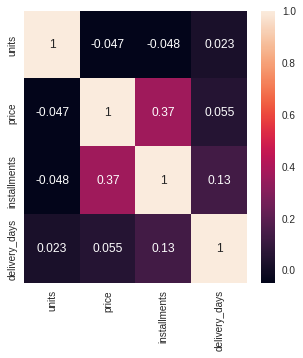

In [52]:
plt.figure(figsize=(5, 5))
sns.heatmap(tabela_full_numerica.corr(), annot=True)

* Installments e price têm uma correlação leve, é melhor investigar mais profundamente essas variáveis com o Churn.
* Installments e delivery_days têm uma correlação leve.

In [53]:
tabela_full_numerica['is_churn'] = tabela_full['is_churn']

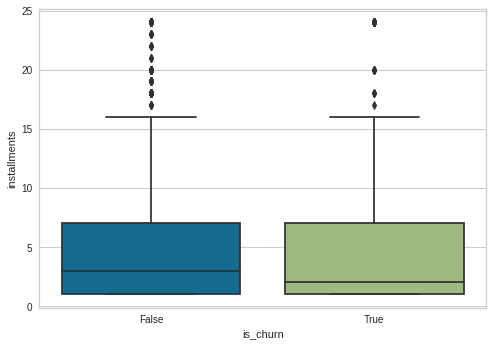

In [54]:
sns.boxplot(data=tabela_full_numerica, x='is_churn', y='installments')

* Existe uma pequena diferença de número de parcelas entre os clientes que deram churn. Aplicarei o teste-T para descobrir se a diferença é significativa ou não.

In [55]:
stats, p_value = ttest_ind((tabela_full_numerica[tabela_full_numerica['is_churn']==False]['installments'].fillna(0)), 
                           tabela_full_numerica[tabela_full_numerica['is_churn']==True]['installments'].fillna(0))
print('stats: %.3f, p-value: %.3f' % (stats, p_value))

stats: 23.790, p-value: 0.000


* A diferença é significativa. O número de parcelas está relacionada ao churn.

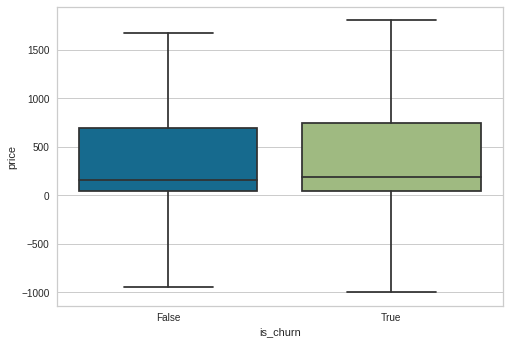

In [56]:
sns.boxplot(data=tabela_full_numerica, x='is_churn', y='price', showfliers=False)

* Existe uma pequena diferença do preço de produto entre os clientes que deram churn. Aplicarei o teste-T para descobrir se a diferença é significativa ou não.

In [57]:
stats, p_value = ttest_ind((tabela_full_numerica[tabela_full_numerica['is_churn']==False]['price']), 
                           tabela_full_numerica[tabela_full_numerica['is_churn']==True]['price'])
print('stats: %.3f, p-value: %.3f' % (stats, p_value))

stats: -1.501, p-value: 0.133


* As médias dos preços são iguais nos dois grupos.

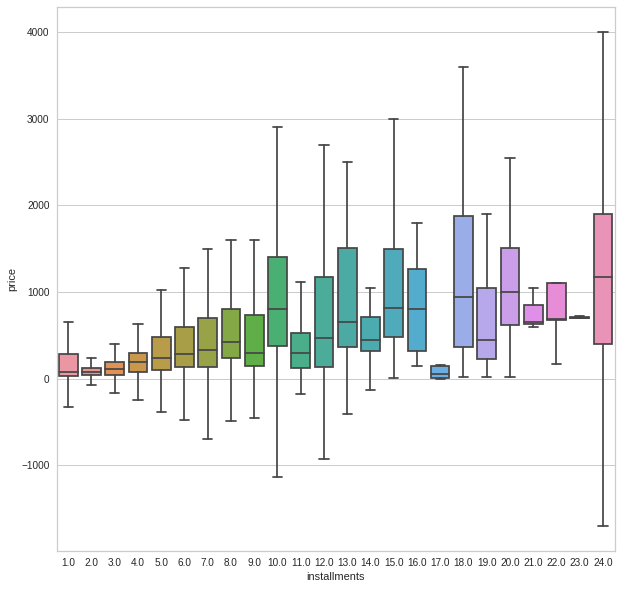

In [58]:
plt.figure(figsize=(10,10))
sns.boxplot(data=tabela_full_numerica, x='installments', y='price', showfliers=False)

* O preço negativo pode significar estorno da compra.


In [59]:
tabela_full_numerica['installments'] = tabela_full_numerica['installments']

# Dividir em parcelmaneto baixo e alto.
tabela_full_numerica['installments_cat'] = pd.cut(x=tabela_full_numerica['installments'],
                                                  bins=[0, 8, 1000],
                                                  labels=['parcelamento_baixo', 'parcelamento_alto'])

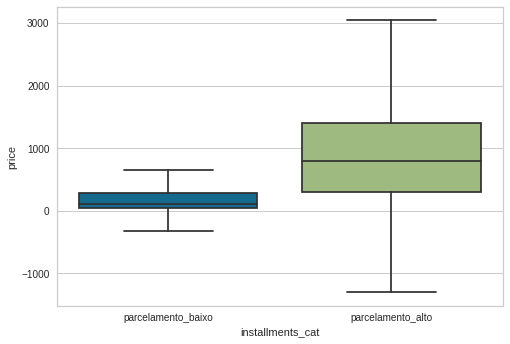

In [60]:
sns.boxplot(data=tabela_full_numerica, x='installments_cat', y='price', showfliers=False)

In [61]:
stats, p_value = ttest_ind((tabela_full_numerica[tabela_full_numerica['installments_cat']=='parcelamento_baixo']['price']), 
                           tabela_full_numerica[tabela_full_numerica['installments_cat']=='parcelamento_alto']['price'])
print('stats: %.3f, p-value: %.3f' % (stats, p_value))

stats: -61.827, p-value: 0.000


* A diferença média do preço de produto é estatisticamente significativa entre os dois grupos criados: parcelamento_baixo e parcelamento_alto.

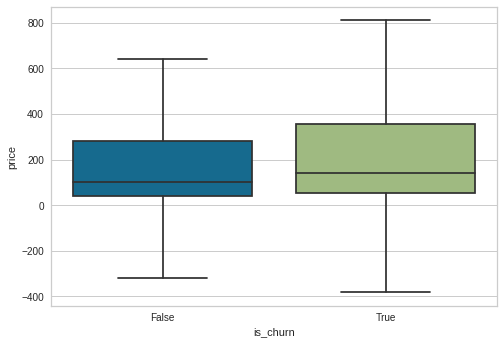

In [62]:
ax = sns.boxplot(data=tabela_full_numerica[tabela_full_numerica['installments_cat']=='parcelamento_baixo'], 
                 x='is_churn', y='price', showfliers=False)

* Para as pessoas que parcelam entre 0 a 8, existe uma diferença entre as médias do preço de produto por grupo (Churn X Sem Churn).


In [63]:
stats, p_value = ttest_ind((tabela_full_numerica[tabela_full_numerica['installments_cat']=='parcelamento_baixo'][tabela_full_numerica['is_churn']==False]['price']), 
                           tabela_full_numerica[tabela_full_numerica['installments_cat']=='parcelamento_baixo'][tabela_full_numerica['is_churn']==True]['price'])
print('stats: %.3f, p-value: %.3f' % (stats, p_value))

stats: -3.463, p-value: 0.001


* A diferença de preço se torna significativa quando o parcelamento é baixo.
* Isso se confirma no grupo de parcelamento alto?

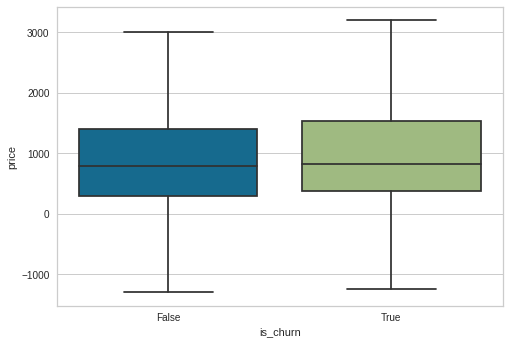

In [64]:
ax = sns.boxplot(data=tabela_full_numerica[tabela_full_numerica['installments_cat']=='parcelamento_alto'], 
                 x='is_churn', y='price', showfliers=False)

In [65]:
stats, p_value = ttest_ind((tabela_full_numerica[tabela_full_numerica['installments_cat']=='parcelamento_alto'][tabela_full_numerica['is_churn']==False]['price']), 
                           tabela_full_numerica[tabela_full_numerica['installments_cat']=='parcelamento_alto'][tabela_full_numerica['is_churn']==True]['price'])
print('stats: %.3f, p-value: %.3f' % (stats, p_value))

stats: -1.514, p-value: 0.130


* Para o cliente de parcelamento alto, a média dos preços de compra entre os grupos de churn e não churn não tem uma diferença estatisticamente significativa.

In [66]:
tabela_full.head(3)

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,...,source,birthdate,state,gender,is_churn,category_lv0,category_lv1,category_lv2,category_lv3,category_lv4
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.90,pm05,NaN,NaN,st07,...,sc08,1972-03-22,st25,cg2,False,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
1,ox076724,cx09976,px04611,2019-07-31 16:06:00,1.0,49.90,pm05,NaN,NaN,st07,...,sc08,1979-12-23,st25,cg1,False,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294
2,ox089080,cx03223,px04611,2019-01-18 12:43:00,1.0,49.89,pm05,NaN,NaN,st07,...,sc08,1969-03-22,st15,cg2,False,mk04,mk04:128,mk04:128:103,mk04:128:103:103,mk04:128:103:103:03294


In [67]:
tabela_full_numerica['installments_cat'].value_counts()

parcelamento_baixo    17047
parcelamento_alto      4944
Name: installments_cat, dtype: int64

### V de Cramer

In [68]:
def cramers_V(var1,var2):
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [69]:
def dataframe_vcramer(tabela_full):
  rows= []

  for var1 in tabela_full:
    col = []
    for var2 in tabela_full:
      cramers =cramers_V(tabela_full[var1], tabela_full[var2]) # Cramer's V test
      col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
    
  cramers_results = np.array(rows)
  df = pd.DataFrame(cramers_results, columns = tabela_full.columns, index =tabela_full.columns)
  return df

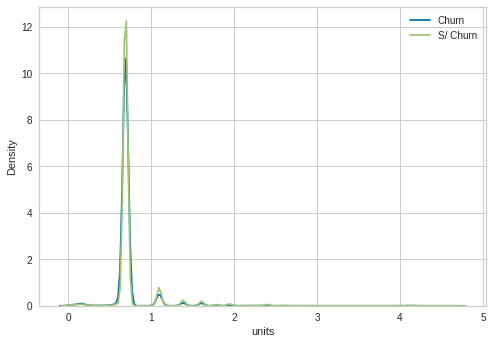

In [70]:
ax = sns.kdeplot(np.log(tabela_full[tabela_full['is_churn']==True]['units'].astype(float)+1))
ax = sns.kdeplot(np.log(tabela_full[tabela_full['is_churn']==False]['units'].astype(float)+1))
plt.legend(labels=["Churn","S/ Churn"])

* As unidades compradas em log não têm uma diferença significativa na distribuição.

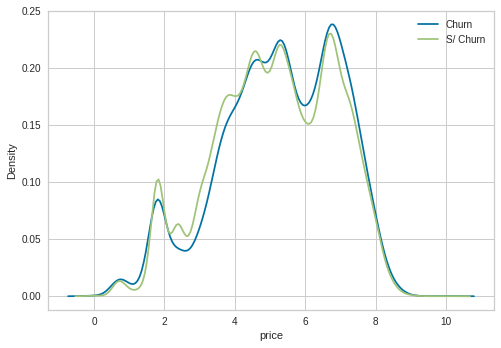

In [71]:
ax = sns.kdeplot(np.log(tabela_full[tabela_full['is_churn']==True]['price'].astype(float)+1))
ax = sns.kdeplot(np.log(tabela_full[tabela_full['is_churn']==False]['price'].astype(float)+1))
plt.legend(labels=["Churn","S/ Churn"])

#Pré-Processamento 01

In [183]:
def train_test_merge(client_train, client_test, client_desafio, orders):
  features_orders = ['device', 
                      'source', 
                      'delivery_state',
                      'datetime', 
                      'installments',
                    'price', 
                    'client_id',
                    'order_id']

  features_client = ['birthdate', 'client_id']

  X_train = pd.merge(orders[features_orders].copy(), 
                              client_train[features_client], 
                              how='right', on='client_id')

  y_train = pd.merge(orders[features_orders].copy(), 
                              client_train[['client_id', 'is_churn']], 
                              how='right', on='client_id')['is_churn']

  X_val = pd.merge(orders[features_orders].copy(), 
                              client_test[features_client], 
                              how='right', on='client_id')

  y_val = pd.merge(orders[features_orders].copy(), 
                              client_test[['client_id', 'is_churn']], 
                              how='right', on='client_id')['is_churn']

  X_desafio = pd.merge(orders[features_orders].copy(), 
                              client_desafio[features_client], 
                              how='right', on='client_id')

  return X_train, X_val, X_desafio, y_train, y_val

In [184]:
X_train, X_val, X_test, y_train, y_val = train_test_merge(client_train, client_test, client_desafio, orders)

In [185]:
X_train.head(3)

,device,source,delivery_state,datetime,installments,price,client_id,order_id,birthdate
0,dv9,sc08,st07,2019-10-07 15:20:00,NaN,49.90,cx05072,ox008433,1972-03-22
1,dv9,sc08,st07,2019-10-11 17:42:00,NaN,69.90,cx05072,ox070389,1972-03-22
2,dv9,sc08,st07,2019-02-08 11:37:00,NaN,54.92,cx03836,ox090390,1966-08-14


In [186]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101005 entries, 0 to 101004
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   device          101005 non-null  object 
 1   source          101005 non-null  object 
 2   delivery_state  101005 non-null  object 
 3   datetime        101005 non-null  object 
 4   installments    21991 non-null   float64
 5   price           101005 non-null  float64
 6   client_id       101005 non-null  object 
 7   order_id        101005 non-null  object 
 8   birthdate       101005 non-null  object 
dtypes: float64(2), object(7)
memory usage: 7.7+ MB


In [187]:
var_categorica = [col for col in X_train if X_train[col].dtype in ['object']]
var_numerica = [col for col in X_train if X_train[col].dtype in ['float64']]

In [188]:
def preprocessing(X_train, 
                  X_val, 
                  y_train, 
                  y_val, 
                  var_numerica, 
                  var_categorica):
  
  X_train_preprocessing = X_train
  X_val_preprocessing = X_val
  y_train_preprocessing = y_train
  y_val_preprocessing = y_val
  # Imputar dados faltantes de variáveis numéricas
  simple_imputer_median = SimpleImputer(strategy='median')
  X_train_preprocessing[var_numerica] = simple_imputer_median.fit_transform(X_train[var_numerica])
  X_val_preprocessing[var_numerica] = simple_imputer_median.fit_transform(X_val[var_numerica])

  # Transformar as variáveis categóricas por LabelEncoder
  label_encoder = LabelEncoder()
  for var in var_categorica:
    if var != 'client_id':
      X_train_preprocessing[var] = label_encoder.fit_transform(X_train[var])
      X_val_preprocessing[var] = label_encoder.fit_transform(X_val[var])
      y_train_preprocessing = label_encoder.fit_transform(y_train)
      y_val_preprocessing = label_encoder.fit_transform(y_val)
  else:
    X_train_preprocessing = X_train_preprocessing.drop('client_id', axis=1)
    X_val_preprocessing = X_val_preprocessing.drop('client_id', axis=1)
    return X_train_preprocessing, X_val_preprocessing, y_train_preprocessing, y_val_preprocessing

In [189]:
X_train_preprocessing, X_val_preprocessing, y_train_preprocessing, y_val_preprocessing = preprocessing(X_train, 
                                                                                                      X_val, 
                                                                                                       y_train, 
                                                                                                       y_val, 
                                                                                                       var_numerica, 
                                                                                                       var_categorica)

In [190]:
def undersampler(X_train_preprocessing, y_train_preprocessing, sampling_strategy=0.5):
  XR, yR = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy).fit_resample(X_train_preprocessing, y_train_preprocessing)
  X_rsamp = pd.DataFrame(columns=X_train_preprocessing.columns, data=XR)
  y_rsamp = pd.Series(data=yR)
  return X_rsamp, y_rsamp

def oversampler(X_train_preprocessing, y_train_preprocessing, sampling_strategy=0.5):
  XR, yR = RandomOverSampler(random_state=42, sampling_strategy=sampling_strategy).fit_resample(X_train_preprocessing, y_train_preprocessing)
  X_rsamp = pd.DataFrame(columns=X_train_preprocessing.columns, data=XR)
  y_rsamp = pd.Series(data=yR)
  return X_rsamp, y_rsamp

# Modelo Baseline

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score

In [81]:
baseline = RandomForestClassifier(random_state=0)

In [82]:
baseline.fit(X_train_preprocessing, y_train_preprocessing)

RandomForestClassifier(random_state=0)

In [83]:
previsão = baseline.predict(X_val_preprocessing)

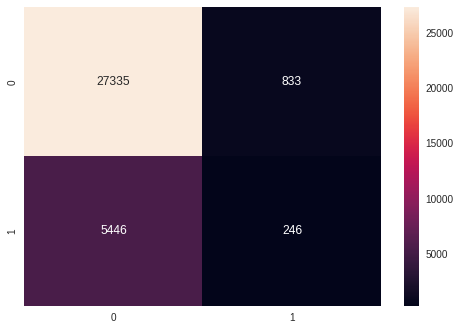

In [84]:
sns.heatmap(confusion_matrix(y_val_preprocessing, previsão), annot=True, fmt='g')

In [85]:
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_preprocessing, previsão),
                                                         recall_score(y_val_preprocessing, previsão),
                                                         f1_score(y_val_preprocessing, previsão)))

Precision: 0.23, Recall: 0.04, F1-Score: 0.07


# EDA 02

## Frequência

In [86]:
X_train

,device,source,delivery_state,datetime,installments,price,client_id,order_id,birthdate
0,8,7,6,49831,3.0,49.90,cx05072,5084,5247
1,8,7,6,50811,3.0,69.90,cx05072,42289,5247
2,8,7,6,7732,3.0,54.92,cx03836,54342,3866
3,8,7,6,7847,3.0,-54.92,cx03836,54342,3866
4,8,7,6,7732,3.0,229.90,cx03836,64207,3866
...,...,...,...,...,...,...,...,...,...
101000,8,7,6,36772,3.0,793.98,cx00861,58594,7572
101001,8,7,6,36772,3.0,5.04,cx00861,43415,7572
101002,8,7,6,36772,3.0,99.00,cx00861,33768,7572
101003,8,7,6,37004,3.0,5.10,cx00861,10722,7572


In [87]:
def frequência(X_train, client_train):  
  frequência = X_train[['datetime', 'client_id']].groupby('client_id').agg(lambda x: x.value_counts())
  # Explodir o datetime em múltiplas colunas
  frequência = frequência['datetime'].apply(pd.Series)
  #df_frequência = frequência.fillna(0).astype('float64')
  df_frequência = frequência.iloc[:, :].sum(axis=1)
  df_frequência = df_frequência.reset_index()
  df_frequência['client_id']=df_frequência['client_id'].astype('object')
  df_EDA_frequência = pd.merge(client_train, df_frequência, how='left', on='client_id')
  df_EDA_frequência.rename(columns={0:'frequência'}, inplace=True)
  return df_EDA_frequência

In [88]:
df_EDA_frequência = frequência(X_train, client_train)

In [89]:
df_EDA_frequência

,client_id,birthdate,state,gender,is_churn,frequência
0,cx05072,1972-03-22,st25,cg2,False,2.0
1,cx03836,1966-08-14,st15,cg1,False,7.0
2,cx08472,1954-08-07,st15,cg1,False,3.0
3,cx12946,1955-11-16,st15,cg1,False,1.0
4,cx19045,1958-10-25,st15,cg2,False,15.0
...,...,...,...,...,...,...
23287,cx05312,1981-08-29,st18,cg1,False,3.0
23288,cx02434,1997-03-15,st04,cg2,False,1.0
23289,cx16024,1950-10-09,st11,cg1,False,3.0
23290,cx11285,1976-07-03,st11,cg2,False,26.0


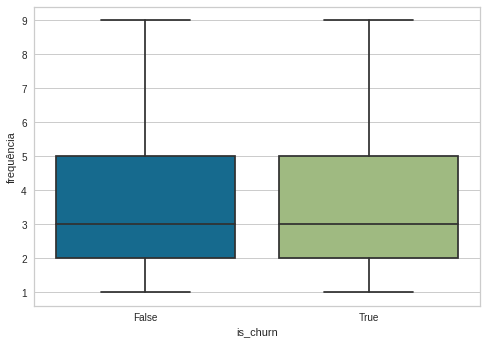

In [90]:
ax = sns.boxplot(data=df_EDA_frequência, x='is_churn', y='frequência', showfliers=False)

In [91]:
df_EDA_frequência[['frequência', 'is_churn']].groupby('is_churn').agg(['mean'])

,frequência
,mean
is_churn,
False,4.398271
True,4.056097


In [92]:
stats, p_value = ttest_ind(df_EDA_frequência[df_EDA_frequência['is_churn']==False]['frequência'], 
                           df_EDA_frequência[df_EDA_frequência['is_churn']==True]['frequência'])
print('stats: %.3f, p_value: %.3f' % (stats, p_value))

stats: 4.306, p_value: 0.000


* A mediana entre os dois grupos é bem semelhante.
* A média entre os dois grupos tem uma diferença estatisticamente significativa.

## Recência

In [93]:
def recência(X_train, client_train):  
  recência = X_train[['datetime', 'client_id']]
  recência['datetime'] = pd.to_datetime(recência['datetime'])
  recência['ano'] = pd.DatetimeIndex(recência['datetime']).year
  recência['mês'] = pd.DatetimeIndex(recência['datetime']).month
  recência = recência[['mês', 'client_id']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_recência = recência['mês'].apply(pd.Series)
  df_recência = df_recência.iloc[:, :].max(axis=1)
  df_recência = df_recência-12
  df_recência = df_recência.reset_index()
  df_recência['client_id'] = df_recência['client_id'].astype('object')
  df_EDA_recência = pd.merge(df_recência, 
                            client_train[['client_id', 'is_churn']], 
                            how='right', 
                            on='client_id')
  df_EDA_recência.rename(columns={0:'recência'}, inplace=True)
  return df_EDA_recência 

In [94]:
df_EDA_recência = recência(X_train, client_train)

In [95]:
df_EDA_recência.head(3)

,client_id,recência,is_churn
0,cx05072,-11,False
1,cx03836,-11,False
2,cx08472,-11,False


In [96]:
df_EDA_recência.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23292 entries, 0 to 23291
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  23292 non-null  object
 1   recência   23292 non-null  int64 
 2   is_churn   23292 non-null  bool  
dtypes: bool(1), int64(1), object(1)
memory usage: 568.7+ KB


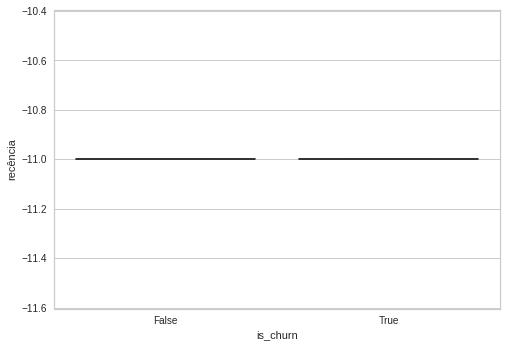

In [97]:
sns.boxplot(data=df_EDA_recência, x='is_churn', y='recência')

In [98]:
stats, p_value = ttest_ind(df_EDA_recência[df_EDA_recência['is_churn']==False]['recência'], 
                           df_EDA_recência[df_EDA_recência['is_churn']==True]['recência'])
print('stats: %.3f, p_value: %.3f' % (stats, p_value))

stats: nan, p_value: nan


* O boxplot apresenta médias de recência significativas estatisticamente ao comparar o grupo de churn e sem churn. 

## Valor monetário

In [99]:
def valor_monetário(X_train, client_train):  
  valor_monetário = X_train[['price', 'client_id']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_valor_monetário = valor_monetário['price'].apply(pd.Series)
  df_valor_monetário = df_valor_monetário.iloc[:, :].mean(axis=1)
  df_EDA_valor_monetário = pd.merge(pd.DataFrame(df_valor_monetário).reset_index(), 
                                    client_train[['client_id', 'is_churn']], how='right', on='client_id')
  df_EDA_valor_monetário.rename(columns={0: 'valor_monetário'}, inplace=True)
  return df_EDA_valor_monetário

In [100]:
df_EDA_valor_monetário = valor_monetário(X_train, client_train)

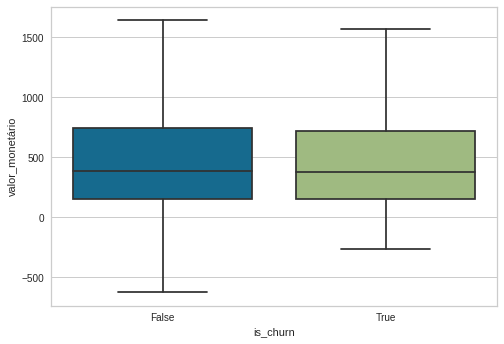

In [101]:
sns.boxplot(data=df_EDA_valor_monetário, x='is_churn', y='valor_monetário', showfliers=False)

In [102]:
stats, p_value = ttest_ind(df_EDA_valor_monetário[df_EDA_valor_monetário['is_churn']==False]['valor_monetário'], 
                           df_EDA_valor_monetário[df_EDA_valor_monetário['is_churn']==True]['valor_monetário'])
print('stats: %.3f, p_value: %.3f' % (stats, p_value))

stats: 2.491, p_value: 0.013


* A diferença das médias é estatisticamente significativa entre os dois grupos.

## Frequência, Recência e Valor Monetário.

In [103]:
df_EDA_freq_rec = pd.merge(df_EDA_frequência, df_EDA_recência, how='inner', on='client_id')
df_EDA_freq_rec_mon = pd.merge(df_EDA_freq_rec, df_EDA_valor_monetário, how='inner', on='client_id')

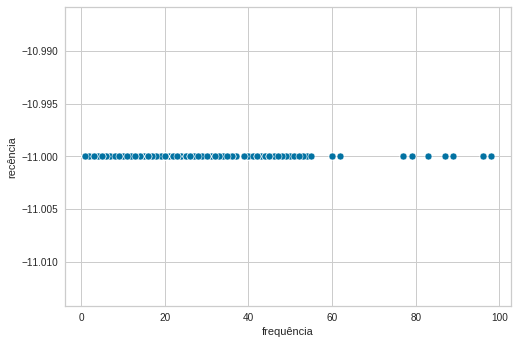

In [104]:
sns.scatterplot(data=df_EDA_freq_rec_mon, x='frequência', y='recência')

In [105]:
df_EDA_freq_rec_mon[['frequência', 'recência', 'valor_monetário']].corr()

,frequência,recência,valor_monetário
frequência,1.000000,NaN,-0.133552
recência,NaN,NaN,NaN
valor_monetário,-0.133552,NaN,1.000000


* A frequência e a recência apresentam uma correlação de 0.3.
* Vou fazer uma nova coluna relacionando essas duas variáveis.
* O valor_monetário tem uma correlação negativa em relação à frequência e recência.

In [106]:
df_EDA_freq_rec_mon['valor_monetário'] = np.log(df_EDA_freq_rec_mon['valor_monetário']+1)
df_EDA_freq_rec_mon['padrão_de_consumo'] = (df_EDA_freq_rec_mon['frequência']*df_EDA_freq_rec_mon['recência'])/df_EDA_freq_rec_mon['valor_monetário']

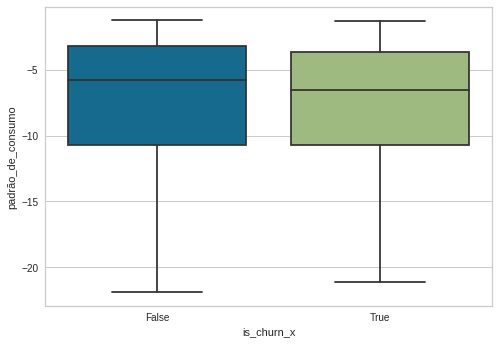

In [107]:
sns.boxplot(data=df_EDA_freq_rec_mon, x='is_churn_x', y='padrão_de_consumo', showfliers=False)

In [108]:
df_EDA_freq_rec_mon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23292 entries, 0 to 23291
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   client_id          23292 non-null  object 
 1   birthdate          23292 non-null  object 
 2   state              23292 non-null  object 
 3   gender             23292 non-null  object 
 4   is_churn_x         23292 non-null  bool   
 5   frequência         23292 non-null  float64
 6   recência           23292 non-null  int64  
 7   is_churn_y         23292 non-null  bool   
 8   valor_monetário    23289 non-null  float64
 9   is_churn           23292 non-null  bool   
 10  padrão_de_consumo  23289 non-null  float64
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 2.2+ MB


In [109]:
df_EDA_freq_rec_mon[['padrão_de_consumo']]

,padrão_de_consumo
0,-5.353797
1,-17.616827
2,-4.555347
3,-2.581390
4,-42.093094
...,...
23287,-5.806177
23288,-1.451650
23289,-5.699521
23290,2130.418348


## Variância das parcelas


In [110]:
df_EDA_client_segment = client_train.copy()

In [111]:
df_EDA_client_segment.head(3)

,client_id,birthdate,state,gender,is_churn
0,cx05072,1972-03-22,st25,cg2,False
1,cx03836,1966-08-14,st15,cg1,False
2,cx08472,1954-08-07,st15,cg1,False


In [112]:
df_EDA_client_segment['ano_nascimento'] = pd.DatetimeIndex(df_EDA_client_segment['birthdate']).year
df_EDA_client_segment = df_EDA_client_segment.drop('birthdate', axis=1)
features = ['client_id', 'state', 'gender', 'is_churn']

In [113]:
orders.head(3)

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08
1,ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08
2,ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08


In [114]:
def variância_parcelas(df_EDA_client_segment, client_train):
  df_EDA_client_installments = pd.merge(df_EDA_client_segment, orders, how='inner', on='client_id')
  df_EDA_client_installments = df_EDA_client_installments[['client_id', 'installments']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_EDA_client_installments = df_EDA_client_installments.installments.apply(pd.Series)
  df_EDA_client_installments = df_EDA_client_installments.iloc[:, :].std(axis=1)**2
  df_EDA_client_installments = pd.DataFrame(df_EDA_client_installments).reset_index()
  df_EDA_client_installments = df_EDA_client_installments.rename(columns={0: 'Variância das parcelas'})
  df_EDA_client_installments = pd.merge(df_EDA_client_installments, client_train, how='inner', on='client_id')
  return df_EDA_client_installments

In [115]:
df_EDA_client_installments = variância_parcelas(df_EDA_client_segment, client_train)

In [116]:
df_EDA_client_installments[['is_churn', 'Variância das parcelas']].groupby('is_churn').agg(['median', 'mean', 'std'])

Variância das parcelas                      
                         median       mean        std
is_churn                                             
False                      10.0  20.811220  34.677264
True                        8.0  18.758364  31.752746

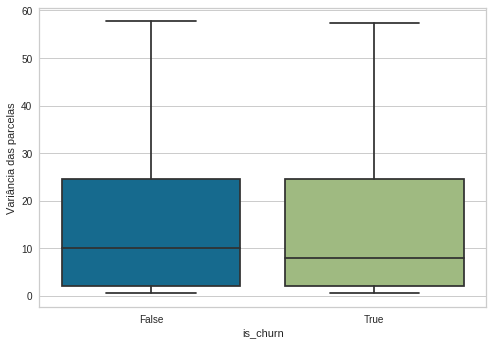

In [117]:
sns.boxplot(data=df_EDA_client_installments, x='is_churn', y='Variância das parcelas', showfliers=False)

In [118]:
stats, p_value = ttest_ind(df_EDA_client_installments[df_EDA_client_installments['is_churn']==False]['Variância das parcelas'].fillna(0),
                          df_EDA_client_installments[df_EDA_client_installments['is_churn']==True]['Variância das parcelas'].fillna(0))
print("stats: %.3f, p_value: %.3f" % (stats, p_value))

stats: 7.924, p_value: 0.000


* A variância das parcelas tem uma diferença estatisticamente significativa entre os dois grupos. 
* Possivelmente, os clientes mais fiéis adaptam o parcelamento da compra de acordo com a circunstância.

## Dias de delivery

In [119]:
df_EDA_soma_delivery_days = client_train.copy()

In [120]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168472 entries, 0 to 168471
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   order_id        168472 non-null  object 
 1   client_id       168472 non-null  object 
 2   product_id      168472 non-null  object 
 3   datetime        168472 non-null  object 
 4   units           168472 non-null  float64
 5   price           168472 non-null  float64
 6   payment_method  168472 non-null  object 
 7   installments    36545 non-null   float64
 8   delivery_days   89642 non-null   float64
 9   delivery_state  168472 non-null  object 
 10  device          168472 non-null  object 
 11  source          168472 non-null  object 
dtypes: float64(4), object(8)
memory usage: 15.4+ MB


In [121]:
def Soma_dias_delivery(df_EDA_soma_delivery_days, client_train):
  df_EDA_soma_delivery_days = pd.merge(df_EDA_soma_delivery_days, orders, how='inner', on='client_id')
  df_EDA_soma_delivery_days = df_EDA_soma_delivery_days[['client_id', 'delivery_days']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_EDA_soma_delivery_days = df_EDA_soma_delivery_days['delivery_days'].apply(pd.Series)
  df_EDA_soma_delivery_days = df_EDA_soma_delivery_days.iloc[:, :].sum(axis=1)
  df_EDA_soma_delivery_days = pd.DataFrame(df_EDA_soma_delivery_days).reset_index()
  df_EDA_soma_delivery_days = df_EDA_soma_delivery_days.rename(columns={0: 'Soma_dias_delivery'})
  df_EDA_soma_delivery_days = pd.merge(df_EDA_soma_delivery_days, client_train, how='inner', on='client_id')
  return df_EDA_soma_delivery_days

In [122]:
df_EDA_soma_delivery_days = Soma_dias_delivery(df_EDA_soma_delivery_days, client_train)

In [123]:
df_EDA_soma_delivery_days.head(3)

,client_id,Soma_dias_delivery,birthdate,state,gender,is_churn
0,cx00002,0.0,1989-04-17,st15,cg2,False
1,cx00004,44.0,1993-01-25,st01,cg2,False
2,cx00005,7.0,1965-08-16,st25,cg1,True


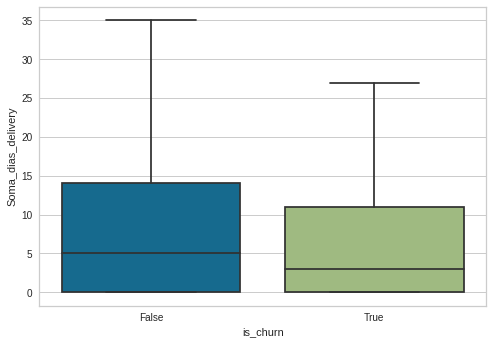

In [124]:
sns.boxplot(data=df_EDA_soma_delivery_days, x='is_churn', y='Soma_dias_delivery', showfliers=False)

* Os clientes que não deram churn esperam mais dias para a entrega do produto, contando todos os dias somados historicamente.
* Essa diferença é estatisticamente significativa?

In [125]:
stats, p_value = ttest_ind(df_EDA_soma_delivery_days[df_EDA_soma_delivery_days['is_churn']==False]['Soma_dias_delivery'],
                           df_EDA_soma_delivery_days[df_EDA_soma_delivery_days['is_churn']==True]['Soma_dias_delivery'])
print('stats: %.3f, p_value: %.3f' % (stats, p_value))

stats: 10.416, p_value: 0.000


* A soma de todos os dias de delivery de cada cliente foi estatisticamente significativa entre os dois grupos.
* Os clientes mais fiéis esperaram mais dias na média do que os clientes de churn.

## Dispositivo

In [126]:
df_EDA_dispositivo = client_train.copy()

In [127]:
def dispositivo(df_EDA_dispositivo, client_train):
  df_EDA_soma_dispositivo = pd.merge(df_EDA_dispositivo, orders, how='inner', on='client_id')
  df_EDA_soma_dispositivo = df_EDA_soma_dispositivo[['client_id', 'device']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_EDA_soma_dispositivo = df_EDA_soma_dispositivo['device'].apply(pd.Series)
  for i in df_EDA_soma_dispositivo:
    df_EDA_soma_dispositivo[i] = LabelEncoder().fit_transform(df_EDA_soma_dispositivo[i])
  df_EDA_soma_dispositivo = df_EDA_soma_dispositivo.iloc[:, :].sum(axis=1)
  df_EDA_soma_dispositivo = pd.DataFrame(df_EDA_soma_dispositivo).reset_index()
  df_EDA_soma_dispositivo = df_EDA_soma_dispositivo.rename(columns={0: 'Soma_dispositivos'})
  df_EDA_soma_dispositivo = pd.merge(df_EDA_soma_dispositivo, client_train, how='inner', on='client_id')
  return df_EDA_soma_dispositivo

In [128]:
df_EDA_soma_dispositivo = dispositivo(df_EDA_dispositivo, client_train)

In [129]:
df_EDA_soma_dispositivo.head(3)

,client_id,Soma_dispositivos,birthdate,state,gender,is_churn
0,cx00002,44,1989-04-17,st15,cg2,False
1,cx00004,32,1993-01-25,st01,cg2,False
2,cx00005,44,1965-08-16,st25,cg1,True


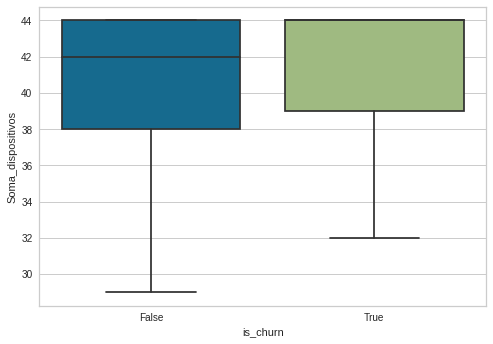

In [130]:
sns.boxplot(data=df_EDA_soma_dispositivo, x='is_churn', y='Soma_dispositivos', showfliers=False)

A soma dos dispositivos tem uma median diferente entre os dois grupos.
Essa diferença é estatisticamente significativa?

In [131]:
df_EDA_soma_dispositivo[['is_churn', 'Soma_dispositivos']].groupby('is_churn').agg(['median', 'mean'])

Soma_dispositivos           
                    median       mean
is_churn                             
False                 42.0  40.278596
True                  44.0  41.565486

In [132]:
stats, p_value = ttest_ind(df_EDA_soma_dispositivo[df_EDA_soma_dispositivo['is_churn']==False]['Soma_dispositivos'],
                           df_EDA_soma_dispositivo[df_EDA_soma_dispositivo['is_churn']==True]['Soma_dispositivos'])
print('stats: %.3f, p_value: %.3f' % (stats, p_value))

stats: -18.077, p_value: 0.000


* A soma dos dispositivos entre os dois grupos tem médias estatisticamente significantes.
* Provavelmente os dispositivos com um números próximos de 9 são móveis.

## Método Pagamento

In [133]:
orders.head(3)

,order_id,client_id,product_id,datetime,units,price,payment_method,installments,delivery_days,delivery_state,device,source
0,ox008433,cx05072,px04611,2019-10-07 15:20:00,1.0,49.9,pm05,NaN,NaN,st07,dv9,sc08
1,ox070389,cx05072,px12305,2019-10-11 17:42:00,1.0,69.9,pm05,NaN,NaN,st07,dv9,sc08
2,ox061137,cx06840,px07033,2019-01-19 13:09:00,1.0,35.9,pm05,NaN,NaN,st07,dv9,sc08


In [134]:
df_EDA_payment = client_train.copy()

In [135]:
def payment(df_EDA_payment, client_train):
  df_EDA_payment_cat = pd.merge(df_EDA_payment, orders, how='inner', on='client_id')
  df_EDA_payment_cat = df_EDA_payment_cat[['client_id', 'payment_method']].astype('object').groupby('client_id').agg(lambda x: x.value_counts().index)
  df_EDA_payment_cat = df_EDA_payment_cat['payment_method'].apply(pd.Series)
  for i in df_EDA_payment_cat:
    df_EDA_payment_cat[i] = LabelEncoder().fit_transform(df_EDA_payment_cat[i])
  df_EDA_payment_cat = df_EDA_payment_cat.iloc[:, :].std(axis=1)
  df_EDA_payment_cat = pd.DataFrame(df_EDA_payment_cat).reset_index()
  df_EDA_payment_cat = df_EDA_payment_cat.rename(columns={0: 'Desvio_padrão_pagamento'})
  df_EDA_payment_cat = pd.merge(df_EDA_payment_cat, client_train, how='inner', on='client_id')
  return df_EDA_payment_cat

In [136]:
df_EDA_payment_cat = payment(df_EDA_payment, client_train)

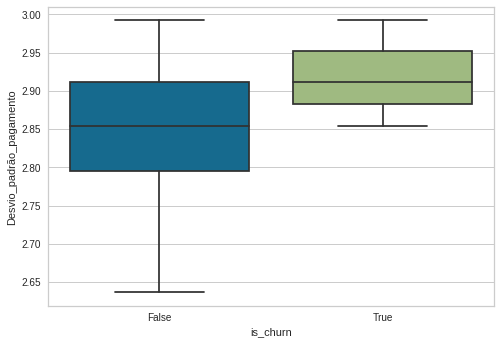

In [137]:
sns.boxplot(data=df_EDA_payment_cat[(df_EDA_payment_cat['Desvio_padrão_pagamento']<3) & (df_EDA_payment_cat['Desvio_padrão_pagamento']>2)], x='is_churn', y='Desvio_padrão_pagamento', showfliers=False)

* O desvio-padrão apresenta medianas diferentes entre os dois grupos.
* O grupo que deu churn provavelmente trocou o dispositivo mais vezes na hora de comprar um produto.
* Será que a diferença é estatisticamente significativa?

In [138]:
stats, p_value = ttest_ind(df_EDA_payment_cat[df_EDA_payment_cat['is_churn']==False]['Desvio_padrão_pagamento'],
                           df_EDA_payment_cat[df_EDA_payment_cat['is_churn']==True]['Desvio_padrão_pagamento'])

print("stats: %.3f, p_value: %.3f" % (stats, p_value))

stats: -4.458, p_value: 0.000


## Tempo

In [139]:
df_EDA_tempo = orders[['datetime', 'client_id', 'order_id']].copy()
df_EDA_tempo = pd.merge(df_EDA_tempo, client_train, how='left', on='client_id')

In [140]:
df_EDA_tempo['mês'] = pd.DatetimeIndex(df_EDA_tempo['datetime']).month
df_EDA_tempo['ano'] = pd.DatetimeIndex(df_EDA_tempo['datetime']).year
df_EDA_tempo['horário'] = pd.DatetimeIndex(df_EDA_tempo['datetime']).hour
df_EDA_tempo['dia_da_semana'] = pd.DatetimeIndex(df_EDA_tempo['datetime']).dayofweek

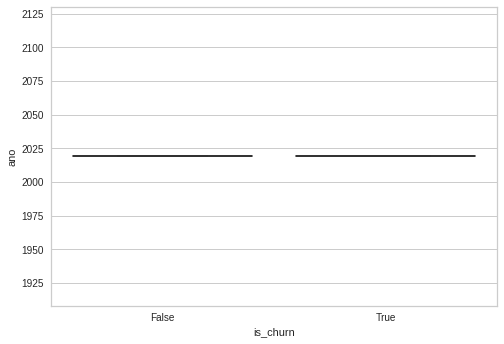

In [141]:
sns.boxplot(data=df_EDA_tempo, x='is_churn', y='ano')

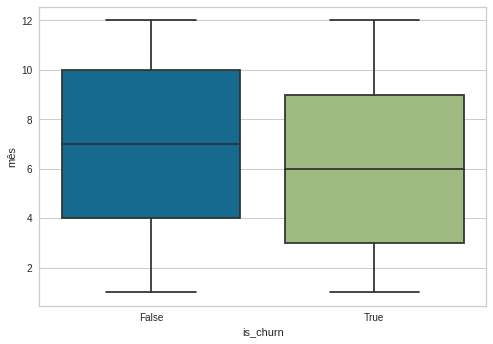

In [142]:
sns.boxplot(data=df_EDA_tempo, x='is_churn', y='mês')

In [143]:
stats, p_value = ttest_ind(df_EDA_tempo[df_EDA_tempo['is_churn']==False]['mês'], 
                           df_EDA_tempo[df_EDA_tempo['is_churn']==True]['mês'])
print('stats: %.3f, P-value: %.3f' % (stats, p_value))

stats: 21.462, P-value: 0.000


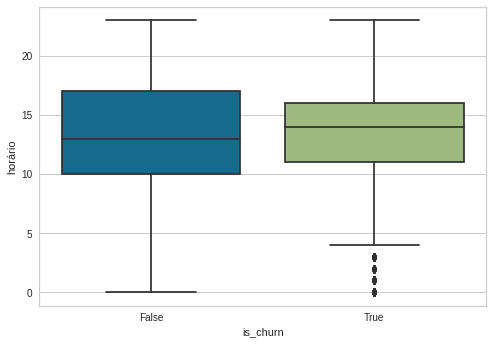

In [144]:
sns.boxplot(data=df_EDA_tempo, x='is_churn', y='horário')

In [145]:
stats, p_value = ttest_ind(df_EDA_tempo[df_EDA_tempo['is_churn']==False]['horário'], 
                           df_EDA_tempo[df_EDA_tempo['is_churn']==True]['horário'])
print('stats: %.3f, P-value: %.3f' % (stats, p_value))

stats: -2.306, P-value: 0.021


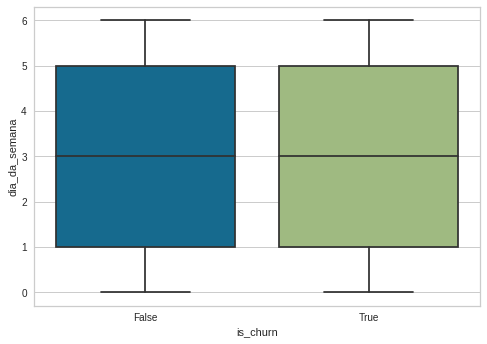

In [146]:
sns.boxplot(data=df_EDA_tempo, x='is_churn', y='dia_da_semana')

#Pré-Processamento 02

In [191]:
X_train, X_val, X_desafio, y_train, y_val = train_test_merge(client_train, client_test, client_desafio, orders)

In [192]:
X_desafio['is_churn']= -1
client_desafio['is_churn'] = -1

In [193]:
frequência_train = frequência(X_train, client_train)
frequência_val = frequência(X_val, client_test)
frequência_desafio = frequência(X_desafio, client_desafio)


recência_train = recência(X_train, client_train)
recência_val = recência(X_val, client_test)
recência_desafio = recência(X_desafio, client_desafio)


valor_monetário_train = valor_monetário(X_train, client_train)
valor_monetário_val = valor_monetário(X_val, client_test)
valor_monetário_desafio = valor_monetário(X_desafio, client_desafio)


variância_parcelas_train = variância_parcelas(client_train, client_train)
variância_parcelas_val = variância_parcelas(client_test, client_test)
variância_parcelas_desafio = variância_parcelas(client_desafio, client_desafio)

soma_dias_delivery_train = Soma_dias_delivery(client_train, client_train)
soma_dias_delivery_val = Soma_dias_delivery(client_test, client_test)
soma_dias_delivery_desafio = Soma_dias_delivery(client_desafio, client_desafio)


dispositivo_train = dispositivo(client_train, client_train)
dispositivo_val = dispositivo(client_test, client_test)
dispositivo_desafio = dispositivo(client_desafio, client_desafio)


payment_train = payment(client_train, client_train)
payment_val = payment(client_test, client_test)
payment_desafio = payment(client_desafio, client_desafio)

In [194]:
X_train_full = pd.merge(frequência_train[['frequência', 'client_id']], 
                        recência_train[['recência', 'client_id']], how='inner', on='client_id') 
X_train_full = pd.merge(X_train_full, valor_monetário_train[['valor_monetário', 'client_id']], how='inner', on='client_id')
X_train_full = pd.merge(X_train_full, variância_parcelas_train[['Variância das parcelas', 'client_id']].fillna(0), how='left', on='client_id')
X_train_full = pd.merge(X_train_full, soma_dias_delivery_train[['Soma_dias_delivery', 'client_id']].fillna(0), how='left', on='client_id')
X_train_full = pd.merge(X_train_full, dispositivo_train[['Soma_dispositivos', 'client_id']].fillna(0), how='left', on='client_id')
X_train_full = pd.merge(X_train_full, payment_train.fillna(payment_train.median()), how='left', on='client_id')
y_train_full = X_train_full['is_churn']
X_train_full = X_train_full.drop('is_churn', axis=1)

X_val_full = pd.merge(frequência_val[['frequência', 'client_id']], 
                        recência_val[['recência', 'client_id']], how='inner', on='client_id') 
X_val_full = pd.merge(X_val_full, valor_monetário_val[['client_id', 'valor_monetário']], how='inner', on='client_id')
X_val_full = pd.merge(X_val_full, variância_parcelas_val[['Variância das parcelas', 'client_id']].fillna(0), how='left', on='client_id')
X_val_full = pd.merge(X_val_full, soma_dias_delivery_val[['Soma_dias_delivery', 'client_id']].fillna(0), how='left', on='client_id')
X_val_full = pd.merge(X_val_full, dispositivo_val[['Soma_dispositivos', 'client_id']].fillna(0), how='left', on='client_id')
X_val_full = pd.merge(X_val_full, payment_val.fillna(0), how='left', on='client_id')
y_val_full = X_val_full['is_churn']
X_val_full = X_val_full.drop('is_churn', axis=1)

X_desafio_full = pd.merge(frequência_desafio[['frequência', 'client_id']], 
                        recência_desafio[['recência', 'client_id']], how='inner', on='client_id') 
X_desafio_full = pd.merge(X_desafio_full, valor_monetário_desafio[['client_id', 'valor_monetário']], how='inner', on='client_id')
X_desafio_full = pd.merge(X_desafio_full, variância_parcelas_desafio[['Variância das parcelas', 'client_id']].fillna(0), how='left', on='client_id')
X_desafio_full = pd.merge(X_desafio_full, soma_dias_delivery_desafio[['Soma_dias_delivery', 'client_id']].fillna(0), how='left', on='client_id')
X_desafio_full = pd.merge(X_desafio_full, dispositivo_desafio[['Soma_dispositivos', 'client_id']].fillna(0), how='left', on='client_id')
X_desafio_full = pd.merge(X_desafio_full, payment_desafio.fillna(0), how='left', on='client_id')
X_desafio_full = X_desafio_full.drop('is_churn', axis=1)

In [195]:
X_desafio_full.shape

(7765, 11)

In [196]:
X_train_full['Variância das parcelas'] = X_train_full['Variância das parcelas'].fillna(0)
X_val_full['Variância das parcelas'] = X_val_full['Variância das parcelas'].fillna(0)
X_desafio_full['Variância das parcelas'] = X_desafio_full['Variância das parcelas'].fillna(0)

In [197]:
X_train_full['padrão_consumo'] = (X_train_full['recência']* X_train_full['frequência'])/ (X_train_full['valor_monetário']+1)
X_val_full['padrão_consumo'] = (X_val_full['recência']* X_val_full['frequência'])/ (X_val_full['valor_monetário']+1)
X_desafio_full['padrão_consumo'] = (X_desafio_full['recência']* X_desafio_full['frequência'])/ (X_desafio_full['valor_monetário']+1)

client_train_preprocessed = client_train.copy()
client_test_preprocessed = client_test.copy()
client_desafio_preprocessed = client_desafio.copy()

client_train_preprocessed['birthdate'] = pd.to_datetime(client_train['birthdate'])
client_test_preprocessed['birthdate'] = pd.to_datetime(client_train['birthdate'])
client_desafio_preprocessed['birthdate'] = pd.to_datetime(client_desafio['birthdate'])

client_train_preprocessed['ano_nascimento'] = pd.DatetimeIndex(client_train['birthdate']).year
client_test_preprocessed['ano_nascimento'] = pd.DatetimeIndex(client_test['birthdate']).year
client_desafio_preprocessed['ano_nascimento'] = pd.DatetimeIndex(client_desafio['birthdate']).year

X_train_full = pd.merge(X_train_full, client_train_preprocessed[['ano_nascimento', 'client_id']], how='inner', on='client_id')
X_val_full = pd.merge(X_val_full, client_test_preprocessed[['ano_nascimento', 'client_id']], how='inner', on='client_id')
X_desafio_full = pd.merge(X_desafio_full, client_desafio_preprocessed[['ano_nascimento', 'client_id']], how='inner', on='client_id')

X_train_full = X_train_full.drop(['state', 'gender', 'birthdate'], axis=1)
X_val_full = X_val_full.drop(['state', 'gender', 'birthdate'], axis=1)
X_desafio_full = X_desafio_full.drop(['state', 'gender', 'birthdate'], axis=1)

In [198]:
orders_preprocessed = orders.copy()
orders_preprocessed = orders_preprocessed.set_index('client_id')
features_cat = ['payment_method', 'delivery_state', 'device', 'source']
feature_time = ['datetime']
orders_features_cat = pd.get_dummies(orders_preprocessed[features_cat])
orders_feature_time = orders_preprocessed[feature_time]
orders_feature_time['mês'] = pd.DatetimeIndex(orders_feature_time['datetime']).month
orders_feature_time['hora'] = pd.DatetimeIndex(orders_feature_time['datetime']).hour

In [199]:
orders_features_cat = orders_features_cat.reset_index()
features = [col for col in orders_preprocessed]

orders_features_cat = orders_features_cat.groupby('client_id').agg(['sum']).fillna(0)
orders_feature_time = orders_feature_time.groupby('client_id').agg(['median']).fillna(0)

orders_preprocessed = orders_preprocessed.reset_index()
orders_feature_time = orders_feature_time.reset_index()

X_train_full = pd.merge(X_train_full, orders_features_cat, how='left', on='client_id')
X_val_full = pd.merge(X_val_full, orders_features_cat, how='left', on='client_id')
X_desafio_full = pd.merge(X_desafio_full, orders_features_cat, how='left', on='client_id')
X_train_full = pd.merge(X_train_full, orders_feature_time, how='left', on='client_id')
X_val_full = pd.merge(X_val_full, orders_feature_time, how='left', on='client_id')
X_desafio_full = pd.merge(X_desafio_full, orders_feature_time, how='left', on='client_id')

X_train_full = X_train_full.drop(['client_id'], axis=1)
X_val_full = X_val_full.drop(['client_id'], axis=1)

# Modelo RandomForestClassifier

## Tuning dos hiperparâmetros

In [156]:
from sklearn.model_selection import RandomizedSearchCV
randomforest = RandomForestClassifier(random_state=0,  
                                      class_weight = {False:1, True:5}) 
params = {'max_leaf_nodes':[5, 10, 15, 20, 25, 30, 35, 40, 45], 
          'max_depth':[5, 10, 15, 20, 25, 30, 35, 40, 45], 
          'n_estimators':[50, 25, 100, 150, 200, 250, 300]}

randomized_search = RandomizedSearchCV(estimator=randomforest,
                                       param_distributions=params,
                                       n_iter=100, 
                                       scoring='f1',
                                       cv=3)
randomized_search.fit(X_train_full, y_train_full)
randomized_search.best_params_

{'max_depth': 15, 'max_leaf_nodes': 40, 'n_estimators': 200}

In [157]:
randomized_search.best_score_

0.35693297766525006

* max_depth  15
* max_leaf_nodes = 40
* n_estimators = 200


## Treino e validação

In [158]:
randomforest = RandomForestClassifier(random_state=0, 
                                      max_leaf_nodes=15, 
                                      max_depth=40, 
                                      n_estimators = 200, 
                                      class_weight = {False:1, True:5}) 

In [159]:
XR, yR = undersampler(X_train_full, y_train_full, sampling_strategy=1)

Precision: 0.23, Recall: 0.80, F1-Score: 0.35


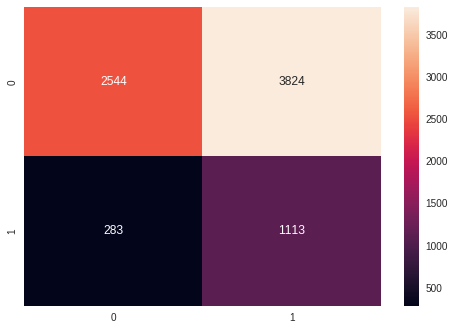

In [160]:
randomforest.fit(X_train_full, y_train_full)
threshold=0.45
previsão_proba_random_forest = randomforest.predict_proba(X_val_full)
previsão_random_forest = (previsão_proba_random_forest[:, 1]>=threshold).astype(int)
sns.heatmap(confusion_matrix(y_val_full, previsão_random_forest), annot=True, fmt='g')
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_random_forest),
                                                         recall_score(y_val_full, previsão_random_forest),
                                                         f1_score(y_val_full, previsão_random_forest)))

## Discrimination Threshold

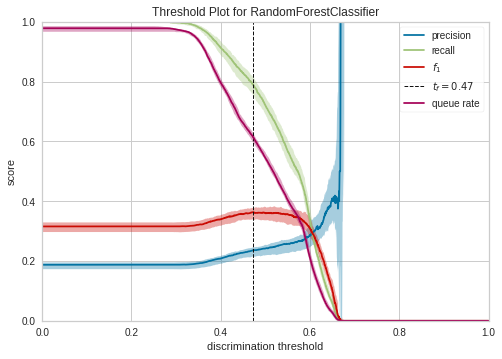

In [161]:
from yellowbrick.classifier import DiscriminationThreshold
discriminationthreshold = DiscriminationThreshold(randomforest)

discriminationthreshold.fit(X_train_full, y_train_full)
discriminationthreshold.show()

## ROC e AUC

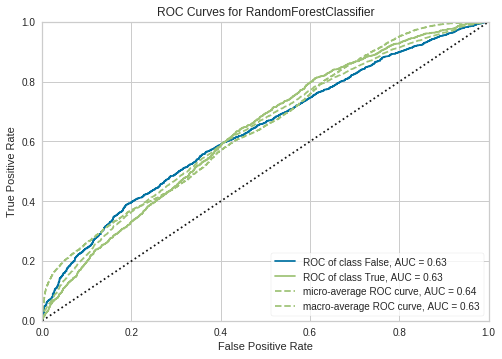

In [162]:
from yellowbrick.classifier import ROCAUC
viz = ROCAUC(randomforest)
viz.fit(X_train_full, y_train_full) 
viz.score(X_val_full, y_val_full)
viz.show()

* AUC de 0.63

## SHAP

In [163]:
# Create object that can calculate shap values
#explainer = shap.TreeExplainer(randomforest)
explainer = shap.Explainer(randomforest, X_val_full)


data_for_prediction = X_val_full.iloc[5]
data_for_prediction = data_for_prediction.values.reshape(1, -1)

# Calculate Shap values
shap_values = explainer.shap_values(X_val_full)

 99%|===================| 15399/15528 [01:37<00:00]       

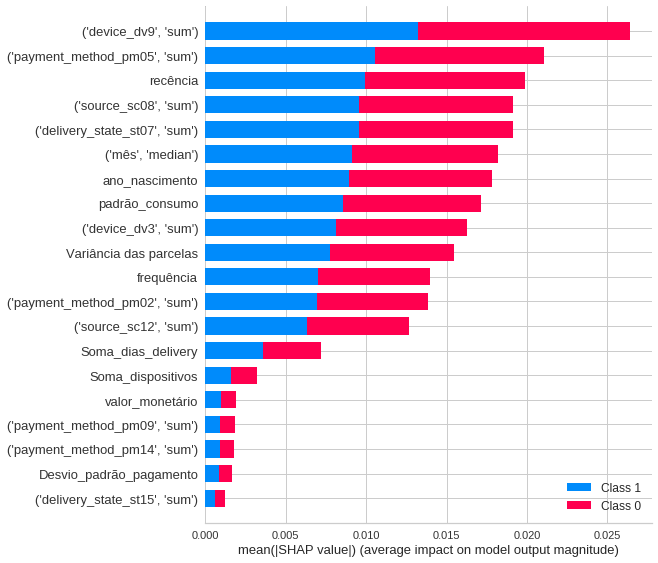

In [164]:
# visualize the first prediction's explanation with a force plot
shap.summary_plot(shap_values, X_val_full)
#shap.initjs()
#shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

**Como as variáveis são tratadas no modelo de acordo com o SHAP value?**
* **As variáveis com maior impacto na probabilidade de churn. Obs.: isso não implica causalidade**

**Top 10 variáveis do modelo.**
* Se usou com frequência o dispositivo 09.
* Se usou com frequência o método de pagamento 05.
* Recência.
* Se usou com frequência o canal de marketing 08.
* Se usou com frequência a entrega de delivery do estado 07.
* Mês 
* ano_nascimento
* Padrão_consumo
* Se usou com frequência o dispositivo 03.
* Variância das parcelas.

## Plot de treino e validação

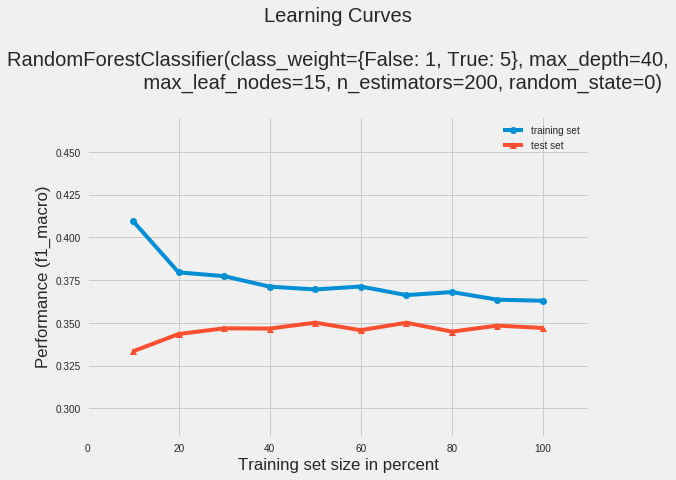

In [165]:
plot_learning_curves(X_train_full, y_train_full, X_val_full, y_val_full, randomforest, scoring='f1_macro')
plt.show()

## Tabela de resultados

In [166]:
from prettytable import PrettyTable
  
columns = ["Modelo", "Verdadeiro positivo", "Falso positivo", "Verdadeiro negativo", "Falso negativo", "Precision", "Recall", "F1-Score"]
  
tabela_resultado = PrettyTable()
  
# Add Columns
# Modelo
tabela_resultado.add_column(columns[0], ["Baseline", 
                                         "RandomForestClassifier padrão + Undersampler padrão",
                                         "RandomForestClassifier padrão + Undersampler custom (sampling_strategy=1) + RMF",
                                         "RandomForestClassifier padrão + Undersampler custom (sampling_strategy=1) + RMF + nascimento",
                                         "RandomForestClassifier padrão + Undersampler custom (sampling_strategy=1) + RMF + nascimento + Variância das parcelas",
                                         "RandomForestClassifier padrão + Undersampler custom (sampling_strategy=1) + RMF + nascimento + Variância das parcelas + Soma_dias_delivery",
                                          "RandomForestClassifier padrão + Undersampler custom (sampling_strategy=1) + RMF + nascimento + Variância das parcelas + Soma_dias_delivery + Soma_dispositvo",
                                         "RandomForestClassifier custom (max_leaf_nodes=6, max_depth=5) + Undersampler custom (sampling_strategy=1) + RMF + nascimento + Variância das parcelas + Soma_dias_delivery",
                                         "RandomForestClassifier custom (random_state=0, max_leaf_nodes=5, max_depth=3, n_estimators = 25, class_weight = {False:1, True:5}) + RMF + nascimento + Variância das parcelas + Soma_dias_delivery + método_pagamento",
                                         "RandomForestClassifier custom (random_state=0, max_leaf_nodes=5, max_depth=3, n_estimators = 100, class_weight = {False:1, True:5}) + RMF + nascimento + Variância das parcelas + Soma_dias_delivery + método_pagamento + Variáveis categóricas do Orders"])
# Verdadeiros positivos
tabela_resultado.add_column(columns[1], [180, 
                                         1486,
                                         716,
                                         808,
                                         763,
                                         763,
                                         551,
                                         933,
                                         991,
                                         1097])
# Falsos positivos
tabela_resultado.add_column(columns[2], [574, 
                                         5916,
                                         3047,
                                         3248,
                                         2821,
                                         2728,
                                         1865,
                                         3147,
                                         3378,
                                         3863])
# Verdadeiros negativos
tabela_resultado.add_column(columns[3], [27594, 
                                         22252,
                                         3321,
                                         3120,
                                         3547,
                                         3640,
                                         4503,
                                         3221,
                                         2990,
                                         2505])
# Falsos negativos
tabela_resultado.add_column(columns[4], [27594, 
                                         4206,
                                         680,
                                         588,
                                         633,
                                         633,
                                         845,
                                         463,
                                         405,
                                         299])
# Precision
tabela_resultado.add_column(columns[5], [0.24, 
                                         0.20,
                                         0.19,
                                         0.20,
                                         0.21,
                                         0.22,
                                         0.23,
                                         0.23,
                                         0.23,
                                         0.22])
# Recall
tabela_resultado.add_column(columns[6], [0.03, 
                                         0.26,
                                         0.51,
                                         0.58,
                                         0.55,
                                         0.55,
                                         0.39,
                                         0.67,
                                         0.71,
                                         0.79])
# F1-Score
tabela_resultado.add_column(columns[7], [0.06, 
                                         0.23,
                                         0.28,
                                         0.30,
                                         0.31,
                                         0.31,
                                         0.29,
                                         0.34,
                                         0.34,
                                         0.35])
  
print(tabela_resultado)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+----------------+---------------------+----------------+-----------+--------+----------+
|                                                                                                                           Modelo                                                                                                                          | Verdadeiro positivo | Falso positivo | Verdadeiro negativo | Falso negativo | Precision | Recall | F1-Score |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------

# Modelo Regressão Logística

In [167]:
lr = LogisticRegression(random_state=0)

## Tuning de hiperparâmetros

In [168]:
param_grid = {'penalty' : ['l1', 'l2'],
            'C' : np.logspace(-4, 4, 20),
            'solver' : ['liblinear'],
            'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:5}, {0:1, 1:6}]}

# Create grid search object

clf = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

# Fit on data
best_clf = clf.fit(X_train_full, y_train_full)



Fitting 5 folds for each of 240 candidates, totalling 1200 fits


In [169]:
best_clf.best_params_

{'C': 78.47599703514607,
 'class_weight': {0: 1, 1: 5},
 'penalty': 'l2',
 'solver': 'liblinear'}

## Treino e validação

Precision: 0.22, Recall: 0.62, F1-Score: 0.33


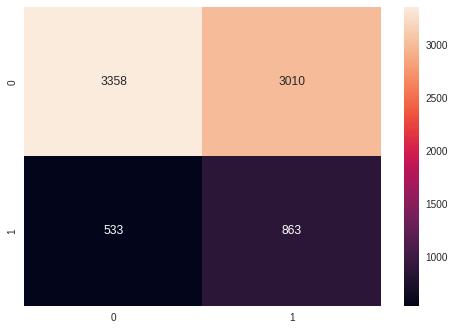

In [170]:
lr_grid_search = LogisticRegression(random_state=0, C=545.5594781168514, 
                                    penalty='l2', solver='liblinear', class_weight={0:1, 1:5})
lr_grid_search.fit(X_train_full, y_train_full)
previsão_proba_logistic_regression = lr_grid_search.predict_proba(X_val_full)
threshold=0.45
previsão_logistic_regression = (previsão_proba_logistic_regression[:, 1]>=threshold).astype(int)
sns.heatmap(confusion_matrix(y_val_full, previsão_logistic_regression), annot=True, fmt='g')
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_logistic_regression),
                                                         recall_score(y_val_full, previsão_logistic_regression),
                                                         f1_score(y_val_full, previsão_logistic_regression)))

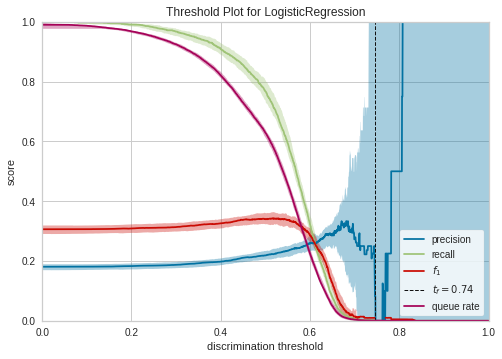

In [171]:
discrimination_plot=discrimination_threshold(lr_grid_search, X_train_full, y_train_full)

## Tabela de resultados

In [172]:
columns = ["Modelo", "Verdadeiro positivo", "Falso positivo", "Verdadeiro negativo", "Falso negativo", "Precision", "Recall", "F1-Score"]
  
tabela_resultado = PrettyTable()
  
# Add Columns
# Modelo
tabela_resultado.add_column(columns[0], ["Baseline", 
                                         "Logistic Regression custom(random_state=0, C=545.5594781168514, penalty='l2', solver='liblinear', class_weight={0:1, 1:5})"])
# Verdadeiros positivos
tabela_resultado.add_column(columns[1], [180,
                                         924])
# Falsos positivos
tabela_resultado.add_column(columns[2], [574,
                                         3208])
# Verdadeiros negativos
tabela_resultado.add_column(columns[3], [27594, 
                                         3160])
# Falsos negativos
tabela_resultado.add_column(columns[4], [27594,
                                        472])
# Precision
tabela_resultado.add_column(columns[5], [0.24,
                                         0.22])
# Recall
tabela_resultado.add_column(columns[6], [0.03,
                                         0.66])
# F1-Score
tabela_resultado.add_column(columns[7], [0.06,
                                         0.33])
  
print(tabela_resultado)

+----------------------------------------------------------------------------------------------------------------------------+---------------------+----------------+---------------------+----------------+-----------+--------+----------+
|                                                           Modelo                                                           | Verdadeiro positivo | Falso positivo | Verdadeiro negativo | Falso negativo | Precision | Recall | F1-Score |
+----------------------------------------------------------------------------------------------------------------------------+---------------------+----------------+---------------------+----------------+-----------+--------+----------+
|                                                          Baseline                                                          |         180         |      574       |        27594        |     27594      |    0.24   |  0.03  |   0.06   |
| Logistic Regression custom(random_state=0, C=545.5

# XGBoost

## Hiperparâmetros

In [173]:
xgb = XGBClassifier(random_state=0,
                    n_estimators=1000,
                    early_stopping_rounds=5)

params = {"learning_rate": np.linspace(0.01, 1, 50),
          "scale_pos_weight": np.linspace(1, 100, 50)}

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=10, scoring='f1', cv=3)

In [174]:
random_search.fit(X_train_full, y_train_full)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(early_stopping_rounds=5,
                                           n_estimators=1000),
                   param_distributions={'learning_rate': array([0.01      , 0.03020408, 0.05040816, 0.07061224, 0.09081633,
       0.11102041, 0.13122449, 0.15142857, 0.17163265, 0.19183673,
       0.21204082, 0.2322449 , 0.25244898, 0.27265306, 0.29285714,
       0.31306122, 0.33326531, 0.35346939, 0.37367347, 0.39387755,
       0....
        41.40816327,  43.42857143,  45.44897959,  47.46938776,
        49.48979592,  51.51020408,  53.53061224,  55.55102041,
        57.57142857,  59.59183673,  61.6122449 ,  63.63265306,
        65.65306122,  67.67346939,  69.69387755,  71.71428571,
        73.73469388,  75.75510204,  77.7755102 ,  79.79591837,
        81.81632653,  83.83673469,  85.85714286,  87.87755102,
        89.89795918,  91.91836735,  93.93877551,  95.95918367,
        97.97959184, 100.        ])},
                   scoring=

In [175]:
random_search.best_params_

{'learning_rate': 0.4140816326530612, 'scale_pos_weight': 55.55102040816326}

{'learning_rate': 0.29285714285714287, 'scale_pos_weight': 35.3469387755102}

## Treino e validação

In [176]:
xgb = XGBClassifier(random_state=0,
                    n_estimators=1000,
                    early_stopping_rounds=5,
                    learning_rate = 0.29,
                    scale_pos_weight = 35
                    )

xgb.fit(X_train_full, y_train_full)

XGBClassifier(early_stopping_rounds=5, learning_rate=0.29, n_estimators=1000,
              scale_pos_weight=35)

In [177]:
previsão_xgb = xgb.predict(X_val_full)

Precision: 0.21, Recall: 0.49, F1-Score: 0.30


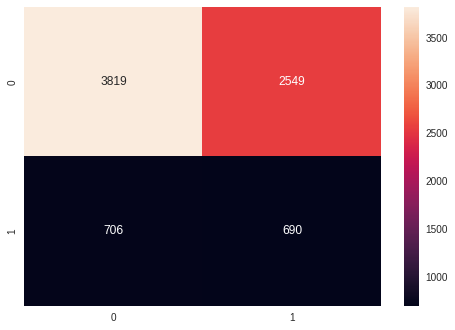

In [178]:
sns.heatmap(confusion_matrix(y_val_full, previsão_xgb), annot=True, fmt='g')
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_xgb),
                                                         recall_score(y_val_full, previsão_xgb),
                                                         f1_score(y_val_full, previsão_xgb)))

# SVM

In [179]:
svc = SVC(random_state=0, class_weight={0:1, 1:5})

## Tuning de hiperparâmetros

In [180]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

clf = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='f1')

# Fit on data
best_clf = clf.fit(X_train_full, y_train_full)


Fitting 5 folds for each of 25 candidates, totalling 125 fits


KeyboardInterrupt: ignored

In [ ]:
best_clf.best_params_

## Treino e validação

In [181]:
svc = SVC(random_state=0, C=1000, gamma=0.0001, kernel='rbf', class_weight={0:1, 1:5})
svc.fit(X_train_full, y_train_full)
previsão_svc = svc.predict(X_val_full)
#previsão_proba_svc = svc.predict_proba(X_val_full)
threshold=0.5
#previsão_svc = (previsão_proba_svc[:, 1]>=threshold).astype(int)
sns.heatmap(confusion_matrix(y_val_full, previsão_svc), annot=True, fmt='g')
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_svc),
                                                         recall_score(y_val_full, previsão_svc),
                                                         f1_score(y_val_full, previsão_svc)))

KeyboardInterrupt: ignored

## Discrimination Threshold

In [ ]:
discriminationthreshold = DiscriminationThreshold(svc)

discriminationthreshold.fit(X_train_full, y_train_full)
discriminationthreshold.show()

## ROC e AUC

In [ ]:
viz = ROCAUC(svc)
viz.fit(X_train_full, y_train_full) 
viz.score(X_val_full, y_val_full)
viz.show()

# Nearest Neighbours

## Tuning de hiperparâmetros

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [ ]:
params = {'n_neighbors':[1, 3, 6, 9],
          'leaf_size':[2, 5, 8, 11],
          'p': [2, 4, 6, 8, 10]}

random_search = RandomizedSearchCV(knn, param_distributions=params, n_iter=10, scoring='f1', cv=3)

In [ ]:
random_search.fit(X_train_full, y_train_full)

In [ ]:
random_search.best_params_

## Treino e validação

In [207]:
knn = KNeighborsClassifier(n_neighbors=1,  
                            algorithm='auto', 
                            leaf_size=2, 
                            p=2, 
                            metric='minkowski', 
                            metric_params=None, n_jobs=-1)

knn.fit(X_train_full, y_train_full)

KNeighborsClassifier(leaf_size=2, n_jobs=-1, n_neighbors=1)

In [208]:
previsão_knn = knn.predict(X_val_full)

In [ ]:
sns.heatmap(confusion_matrix(y_val_full, previsão_knn), annot=True, fmt='g')
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_knn),
                                                         recall_score(y_val_full, previsão_knn),
                                                         f1_score(y_val_full, previsão_knn)))

# GaussianNB

In [201]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

## Tuning de hiperparâmetros

In [ ]:
params = {'var_smoothing': np.linspace(1e-15, 1e-2, num=10000)}

random_search = RandomizedSearchCV(naive_bayes, param_distributions=params, n_iter=10, scoring='f1', cv=3)

In [ ]:
random_search.fit(X_train_full, y_train_full)

In [ ]:
random_search.best_score_

In [ ]:
random_search.best_params_

## Treino e validação

In [202]:
naive_bayes = GaussianNB(var_smoothing=8.8e-05)

In [203]:
naive_bayes.fit(X_train_full, y_train_full)

GaussianNB(var_smoothing=8.8e-05)

In [204]:
previsão_naive_bayes = naive_bayes.predict(X_val_full)

In [ ]:
sns.heatmap(confusion_matrix(y_val_full, previsão_naive_bayes), annot=True, fmt='g')
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_naive_bayes),
                                                         recall_score(y_val_full, previsão_naive_bayes),
                                                         f1_score(y_val_full, previsão_naive_bayes)))

In [ ]:
discriminationthreshold = DiscriminationThreshold(naive_bayes)

discriminationthreshold.fit(X_train_full, y_train_full)
discriminationthreshold.show()

## ROC e AUC

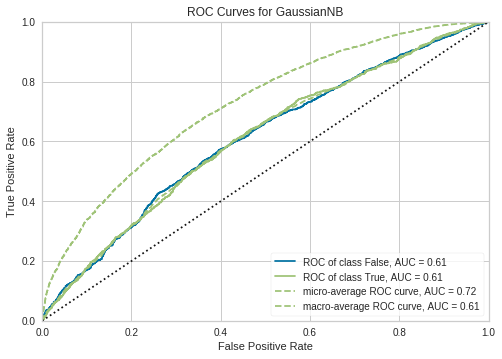

In [205]:
viz = ROCAUC(naive_bayes)
viz.fit(X_train_full, y_train_full) 
viz.score(X_val_full, y_val_full)
viz.show()

# Avaliar potencial ensemble ótimo

In [255]:
potencial_ensemble = pd.DataFrame({'target': y_val_full,
                                  'randomforest': previsão_random_forest,
                                  'logistic regression': previsão_logistic_regression,
                                   'naive_bayes': previsão_naive_bayes,
                                  'knn': previsão_knn})

potencial_ensemble = potencial_ensemble.astype(int).dropna(axis=0)

In [256]:
potencial_ensemble

,target,randomforest,logistic regression,naive_bayes,knn
0,0,1,1,1,0
1,0,1,1,1,0
2,0,1,1,1,0
3,0,1,1,1,0
4,0,1,1,1,0
...,...,...,...,...,...
7759,0,0,0,0,0
7760,0,1,1,0,0
7761,0,1,1,1,0
7762,0,0,0,0,0


In [257]:
potencial_ensemble['previsão ótima'] = np.nan
colunas = ['randomforest', 'logistic regression', 'knn']
potencial_ensemble = potencial_ensemble.astype('float64')
for i in range(len(potencial_ensemble)):
  if potencial_ensemble['target'][i]==potencial_ensemble['randomforest'][i]:
    potencial_ensemble['previsão ótima'][i]=potencial_ensemble['randomforest'][i]
  elif potencial_ensemble['target'][i]==potencial_ensemble['logistic regression'][i]:
    potencial_ensemble['previsão ótima'][i]=potencial_ensemble['logistic regression'][i]
  elif potencial_ensemble['target'][i]==potencial_ensemble['knn'][i]:
    potencial_ensemble['previsão ótima'][i]=potencial_ensemble['knn'][i]
  elif potencial_ensemble['target'][i]==potencial_ensemble['knn'][i]:
    potencial_ensemble['previsão ótima'][i]=potencial_ensemble['naive_bayes'][i]
  elif potencial_ensemble['target'][i]==1.0:
    potencial_ensemble['previsão ótima'][i] = potencial_ensemble['previsão ótima'][i] = 0
  elif potencial_ensemble['target'][i]==0:
    potencial_ensemble['previsão ótima'][i] = potencial_ensemble['previsão ótima'][i] = 1

In [258]:
potencial_ensemble.sample(10)

,target,randomforest,logistic regression,naive_bayes,knn,previsão ótima
7528,1.0,0.0,0.0,0.0,0.0,0.0
1261,0.0,1.0,0.0,0.0,0.0,0.0
5156,0.0,1.0,1.0,1.0,0.0,0.0
1460,0.0,1.0,1.0,1.0,0.0,0.0
2017,0.0,1.0,0.0,0.0,0.0,0.0
760,1.0,1.0,1.0,1.0,0.0,1.0
864,0.0,1.0,0.0,0.0,0.0,0.0
942,0.0,1.0,1.0,0.0,0.0,0.0
6221,0.0,0.0,0.0,1.0,1.0,0.0
1557,1.0,1.0,1.0,1.0,0.0,1.0


In [259]:
row = {'randomforest': f1_score(potencial_ensemble.target,  potencial_ensemble['randomforest']),
       'logistic regression' : f1_score(potencial_ensemble.target, potencial_ensemble['logistic regression']),
       'knn': f1_score(potencial_ensemble.target, potencial_ensemble['knn']),
       'naive_bayes': f1_score(potencial_ensemble.target, potencial_ensemble['naive_bayes']),
       'previsão ótima' : f1_score(potencial_ensemble.target, potencial_ensemble['previsão ótima'])}

In [260]:
potencial_ensemble = potencial_ensemble.append(row, ignore_index=True)

In [261]:
potencial_ensemble[-1:]

,target,randomforest,logistic regression,naive_bayes,knn,previsão ótima
7764,NaN,0.351492,0.327576,0.315436,0.18819,0.753772


* Potencial do ensemble teórico máximo: 0.75 de f1-score

# Ensemble

In [253]:
df_previsões = pd.DataFrame({'previsão_logistic_regression': previsão_logistic_regression, 
                             'previsão_random_forest': previsão_random_forest,
                             'previsão_knn': previsão_knn,
                             'previsão_naive_bayes': previsão_naive_bayes})

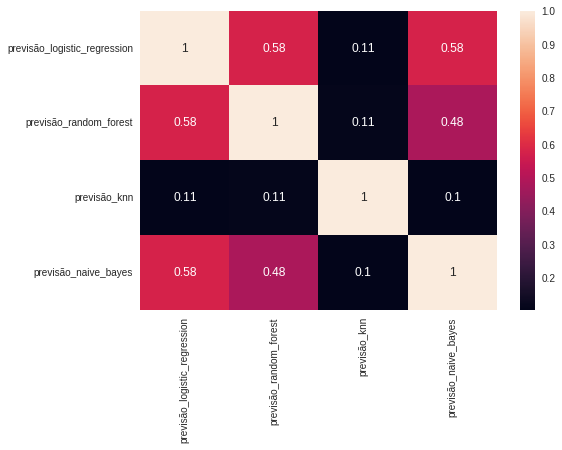

In [254]:
sns.heatmap(df_previsões.corr(), annot=True)

## Ensemble Voting

In [262]:
from sklearn.ensemble import VotingClassifier
clf1 = RandomForestClassifier(random_state=0, 
                              max_leaf_nodes=5, 
                              max_depth=3, 
                              n_estimators = 100, 
                              class_weight = {False:1, True:5}) 

clf2 = LogisticRegression(random_state=0, C=545.5594781168514, 
                                    penalty='l2', solver='liblinear', class_weight={0:1, 1:5})

clf3 = KNeighborsClassifier(n_neighbors=1,  
                            algorithm='auto', 
                            leaf_size=2, 
                            p=2, 
                            metric='minkowski', 
                            metric_params=None, n_jobs=-1)

clf4 = GaussianNB(var_smoothing=8.8e-05)

clf5 = XGBClassifier(random_state=0,
                    n_estimators=1000,
                    early_stopping_rounds=5,
                    learning_rate = 0.29,
                    scale_pos_weight = 35)

voting = VotingClassifier(estimators=[('rf', clf1), 
                                      ('lr', clf2), 
                                      ('knn', clf3),
                                      ('naive_bayes', clf4)], 
                          voting='soft', 
                          flatten_transform=False, weights=[50, 5, 1, 1])

In [263]:
voting.fit(X_train_full, y_train_full)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight={False: 1,
                                                                   True: 5},
                                                     max_depth=3,
                                                     max_leaf_nodes=5,
                                                     random_state=0)),
                             ('lr',
                              LogisticRegression(C=545.5594781168514,
                                                 class_weight={0: 1, 1: 5},
                                                 random_state=0,
                                                 solver='liblinear')),
                             ('knn',
                              KNeighborsClassifier(leaf_size=2, n_jobs=-1,
                                                   n_neighbors=1)),
                             ('naive_bayes',
                              GaussianNB(var_smoothing=8.8e

In [264]:
threshold = 0.5
previsão_voting = (voting.predict_proba(X_val_full)[:, 1]>=threshold).astype(int)

In [265]:
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_voting),
                                                         recall_score(y_val_full, previsão_voting),
                                                         f1_score(y_val_full, previsão_voting)))

Precision: 0.24, Recall: 0.61, F1-Score: 0.34


## Ensemble stacking

In [266]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


In [267]:
estimators = [('randomforest', randomforest),
              ('knn', knn),
              ('nb', naive_bayes)]

final_estimator = make_pipeline(StandardScaler(), LogisticRegression(random_state=0,
                                                                     penalty='l1',
                                                                     solver='liblinear',
                                                                     class_weight={0:1, 1:5}))

stacking_ensemble = StackingClassifier(estimators=estimators, 
                                       final_estimator=final_estimator,
                                       stack_method='predict_proba')

In [268]:
stacking_ensemble.fit(X_train_full, y_train_full)

StackingClassifier(estimators=[('randomforest',
                                RandomForestClassifier(class_weight={False: 1,
                                                                     True: 5},
                                                       max_depth=40,
                                                       max_leaf_nodes=15,
                                                       n_estimators=200,
                                                       random_state=0)),
                               ('knn',
                                KNeighborsClassifier(leaf_size=2, n_jobs=-1,
                                                     n_neighbors=1)),
                               ('nb', GaussianNB(var_smoothing=8.8e-05))],
                   final_estimator=Pipeline(steps=[('standardscaler',
                                                    StandardScaler()),
                                                   ('logisticregression',
                             

In [269]:
previsão_proba_stacking = stacking_ensemble.predict_proba(X_val_full)

In [270]:
threshold = 0.5
previsão_stacking = (previsão_proba_stacking[:, 1]>=threshold).astype(int)

Precision: 0.24, Recall: 0.60, F1-Score: 0.35


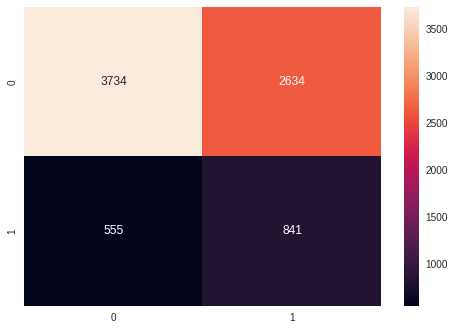

In [271]:
sns.heatmap(confusion_matrix(y_val_full, 
                             previsão_stacking), 
            annot=True, fmt='g')

print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_stacking),
                                                         recall_score(y_val_full, previsão_stacking),
                                                         f1_score(y_val_full, previsão_stacking)))

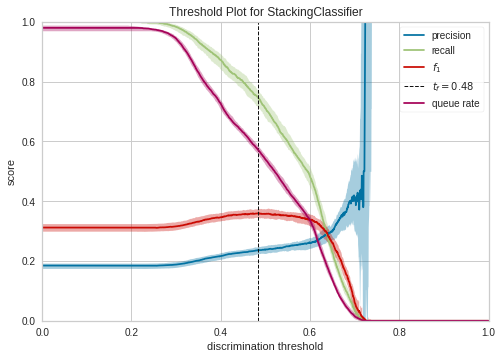

In [272]:
from yellowbrick.classifier import DiscriminationThreshold

discriminationthreshold = DiscriminationThreshold(stacking_ensemble)

discriminationthreshold.fit(X_train_full, y_train_full)
discriminationthreshold.show()

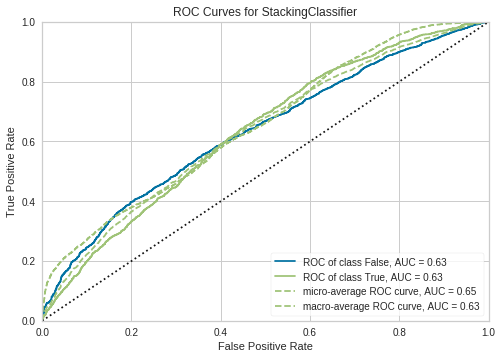

In [273]:
from yellowbrick.classifier import ROCAUC
viz = ROCAUC(stacking_ensemble)
viz.fit(X_train_full, y_train_full) 
viz.score(X_val_full, y_val_full)
viz.show()

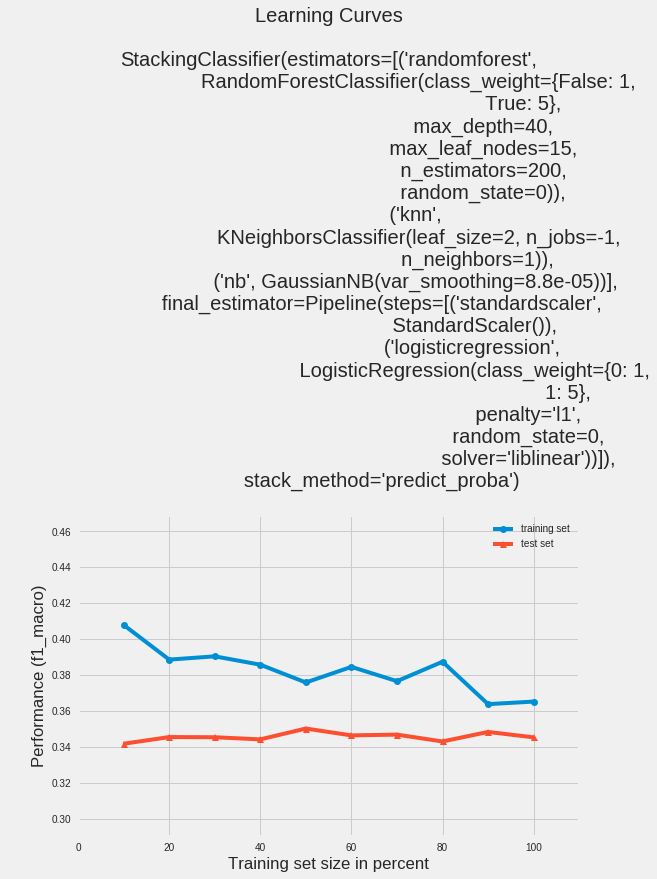

In [274]:
plot_learning_curves(X_train_full, y_train_full, X_val_full, y_val_full, 
                     stacking_ensemble, scoring='f1_macro', legend_loc='Ensemble stacking')
plt.show()

## Bagging de stacking

In [275]:
from sklearn.ensemble import BaggingClassifier

estimators = [('randomforest', randomforest),
              ('nb', naive_bayes)]

final_estimator = LogisticRegression(random_state=0,
                                    penalty='l1',
                                    solver='liblinear',
                                    class_weight={0:1, 1:5})

stacking_ensemble = StackingClassifier(estimators=estimators, 
                                       final_estimator=final_estimator,
                                       stack_method='predict_proba')

bagging_stacking = BaggingClassifier(base_estimator=stacking_ensemble, n_estimators=50)
bagging_stacking.fit(X_train_full, y_train_full)
previsão_bagging_stacking = bagging_stacking.predict(X_val_full)

Precision: 0.24, Recall: 0.59, F1-Score: 0.34


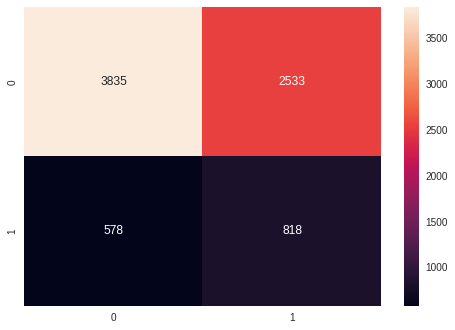

In [276]:
sns.heatmap(confusion_matrix(y_val_full, 
                             previsão_bagging_stacking), 
            annot=True, fmt='g')

print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_bagging_stacking),
                                                         recall_score(y_val_full, previsão_bagging_stacking),
                                                         f1_score(y_val_full, previsão_bagging_stacking)))

Precision: 0.26, Recall: 0.39, F1-Score: 0.31


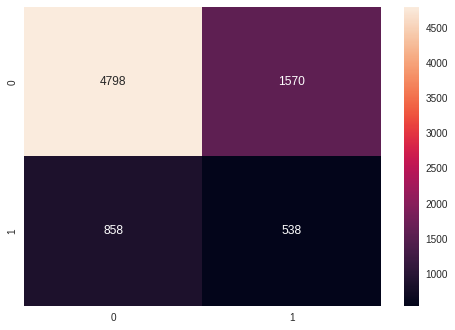

In [277]:
bagging_lr = BaggingClassifier(base_estimator=lr_grid_search, n_estimators=50)
bagging_lr.fit(X_train_full, y_train_full)
previsão_bagging_lr = bagging_lr.predict(X_val_full)

sns.heatmap(confusion_matrix(y_val_full, 
                             previsão_bagging_lr), 
            annot=True, fmt='g')

print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_bagging_lr),
                                                         recall_score(y_val_full, previsão_bagging_lr),
                                                         f1_score(y_val_full, previsão_bagging_lr)))

## Voting de stacking 

In [278]:
voting = VotingClassifier(estimators=[('stacking_ensemble_lr', stacking_ensemble), 
                                      ('random_forest', randomforest),
                                      ('bagging_lr', bagging_lr)], 
                          voting='soft', 
                          flatten_transform=False, weights=[2, 3, 1])

In [279]:
voting.fit(X_train_full, y_train_full)

VotingClassifier(estimators=[('stacking_ensemble_lr',
                              StackingClassifier(estimators=[('randomforest',
                                                              RandomForestClassifier(class_weight={False: 1,
                                                                                                   True: 5},
                                                                                     max_depth=40,
                                                                                     max_leaf_nodes=15,
                                                                                     n_estimators=200,
                                                                                     random_state=0)),
                                                             ('nb',
                                                              GaussianNB(var_smoothing=8.8e-05))],
                                                 final_estimator=LogisticR

In [280]:
previsão_voting = voting.predict(X_val_full)

Precision: 0.24, Recall: 0.59, F1-Score: 0.35


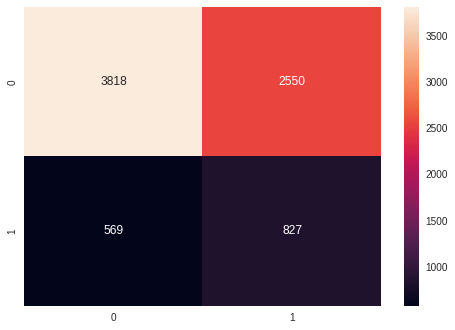

In [281]:
sns.heatmap(confusion_matrix(y_val_full, 
                             previsão_voting), 
            annot=True, fmt='g')

print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_voting),
                                                         recall_score(y_val_full, previsão_voting),
                                                         f1_score(y_val_full, previsão_voting)))

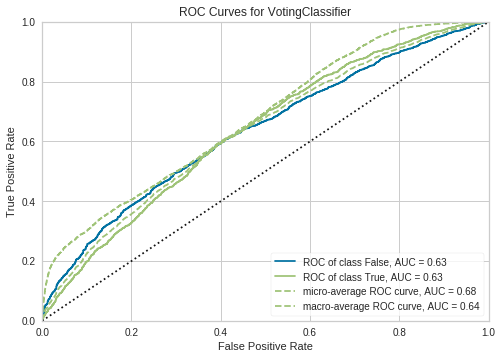

In [282]:
viz = ROCAUC(voting)
viz.fit(X_train_full, y_train_full) 
viz.score(X_val_full, y_val_full)
viz.show()

## Tabela de Resultados

In [283]:
columns = ["Modelo", 
           "Verdadeiro positivo", 
           "Falso positivo", 
           "Verdadeiro negativo", 
           "Falso negativo", 
           "Precision", 
           "Recall", 
           "F1-Score"]
  
tabela_resultado = PrettyTable()

# Add Columns
# Modelo
tabela_resultado.add_column(columns[0], ["Ensemble de svc, randomforest e xgb, e meta-modelo de Logistic Regression",
                                         "Ensemble de knn, randomforest e meta-modelo de Logistic Regression",
                                         "Voting"])
# Verdadeiros positivos
tabela_resultado.add_column(columns[1], [841,
                                         831,
                                         833])
# Falsos positivos
tabela_resultado.add_column(columns[2], [2633,
                                         2584,
                                         2556])
# Verdadeiros negativos
tabela_resultado.add_column(columns[3], [3735,
                                         3784,
                                         3812])
# Falsos negativos
tabela_resultado.add_column(columns[4], [555,
                                         565,
                                         563])
# Precision
tabela_resultado.add_column(columns[5], [0.24,
                                         0.24,
                                         0.25])
# Recall
tabela_resultado.add_column(columns[6], [0.60,
                                         0.60,
                                         0.60])
# F1-Score
tabela_resultado.add_column(columns[7], [0.35,
                                         0.35,
                                         0.35])
  
print(tabela_resultado)

+---------------------------------------------------------------------------+---------------------+----------------+---------------------+----------------+-----------+--------+----------+
|                                   Modelo                                  | Verdadeiro positivo | Falso positivo | Verdadeiro negativo | Falso negativo | Precision | Recall | F1-Score |
+---------------------------------------------------------------------------+---------------------+----------------+---------------------+----------------+-----------+--------+----------+
| Ensemble de svc, randomforest e xgb, e meta-modelo de Logistic Regression |         841         |      2633      |         3735        |      555       |    0.24   |  0.6   |   0.35   |
|     Ensemble de knn, randomforest e meta-modelo de Logistic Regression    |         831         |      2584      |         3784        |      565       |    0.24   |  0.6   |   0.35   |
|                                   Voting                  

# Random Forest com as 15 features mais importantes do modelo

In [284]:
from sklearn.inspection import permutation_importance

def feature_imp(modelo, X_val, y_val, n_repeats=10, random_state=0):
    result = permutation_importance(modelo, 
                                    X_val, y_val, 
                                    n_repeats=10,
                                    random_state=0)
    
    result_df = pd.DataFrame({'Correlação': result.importances_mean})
    feature_name = pd.DataFrame({'Features': X_val.columns})
    feature_importance = pd.concat([feature_name, result_df], join='inner', axis=1)
    return feature_importance.sort_values(by='Correlação', ascending=False)

In [285]:
var_importantes = feature_imp(modelo=randomforest, 
                              X_val=X_val_full, 
                              y_val=y_val_full, 
                              n_repeats=10, 
                              random_state=0)

In [286]:
var_importantes_positive = var_importantes[var_importantes['Correlação']>0.001].iloc[:10]

In [287]:
var_importantes_negative = var_importantes[var_importantes['Correlação']<-0.001].iloc[-10:]

In [288]:
top_15_features = pd.concat([var_importantes_positive, var_importantes_negative], axis=0)

In [289]:
top_15_features = top_15_features.Features.values.tolist()

In [290]:
X_train_full_top_15_features = X_train_full[top_15_features]
X_val_full_top_15_features = X_val_full[top_15_features]
X_desafio_full_top_15_features = X_desafio_full[top_15_features]
X_desafio_full_top_15_features['client_id'] = X_desafio_full['client_id']

In [291]:
randomforest_top_15_features = randomforest
randomforest_top_15_features.fit(X_train_full_top_15_features, y_train_full)

RandomForestClassifier(class_weight={False: 1, True: 5}, max_depth=40,
                       max_leaf_nodes=15, n_estimators=200, random_state=0)

In [292]:
previsão_randomforest_top_15_features = randomforest_top_15_features.predict_proba(X_val_full_top_15_features)
threshold = 0.49
previsão_randomforest_top_15_features = (previsão_randomforest_top_15_features[:, 1]>=threshold).astype(int)

Precision: 0.23, Recall: 0.73, F1-Score: 0.35


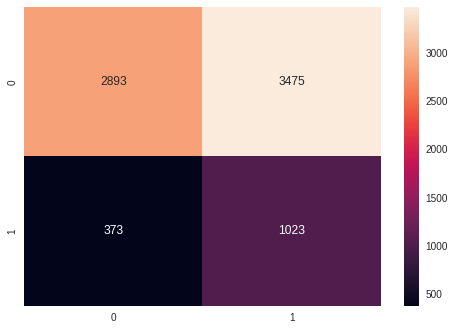

In [293]:
sns.heatmap(confusion_matrix(y_val_full, previsão_randomforest_top_15_features), annot=True, fmt='g')
print('Precision: %.2f, Recall: %.2f, F1-Score: %.2f' % (precision_score(y_val_full, previsão_randomforest_top_15_features),
                                                         recall_score(y_val_full, previsão_randomforest_top_15_features),
                                                         f1_score(y_val_full, previsão_randomforest_top_15_features)))

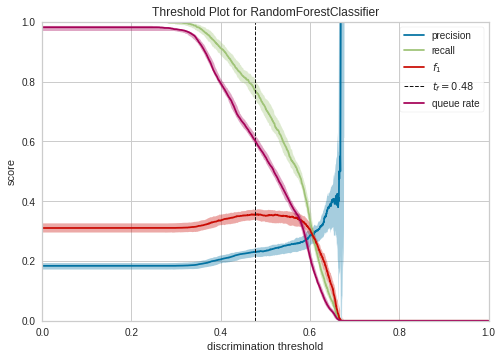

In [294]:
discriminationthreshold = DiscriminationThreshold(randomforest_top_15_features)

discriminationthreshold.fit(X_train_full, y_train_full)
discriminationthreshold.show()

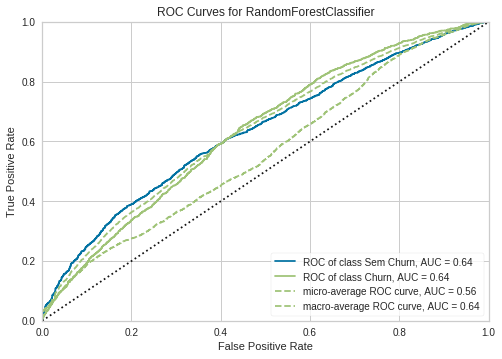

In [295]:
viz = ROCAUC(randomforest_top_15_features, classes=['Sem Churn', 'Churn'])
viz.fit(X_train_full_top_15_features, y_train_full) 
viz.score(X_val_full_top_15_features, y_val_full)
viz.show()

* O AUC está melhor que o do random forest treinado com praticamente 70 variáveis!
* As 15 features mais importantes melhoraram o desempenho do AUC.
* Provavelmente o desempenho é mais estável nesse modelo com apenas 15 variáveis do que o modelo com 70 variáveis.

# Conclusão

## Justificativas das métricas

* As métricas escolhidas em ordem de importância, da maior para a menor, foram: F1-score, recall e precision.
* O f1-score é a combinação de recall e precision de forma equilibrada.
* O Recall foi utilizado para saber quantos clientes foram detectados como churn que deram churn de fato.
* O Precision é uma métrica para saber a proporção de verdadeiros positivos em relação ao total de detecções de churn.

## Observações sobre modelagem


* O melhor modelo foi o RandomForest com um f1-score de 0.35, Recall de 0.8 e Precision de 0.23.
* O modelo não separa bem os clientes mais fiéis dos que deram churn.
* É necessário captar mais dados sobre os clientes.

## Insights dos dados

**Top 15 variáveis do modelo de acordo com importância de feature.**
* delivery_state_st07
* ano_nascimento
* payment_method_pm05
* frequência
* source_sc08
* recência
* payment_method_pm14
* payment_method_pm09
* mês
* padrão_consumo
* Soma_dias_delivery
* payment_method_pm02
* source_sc12
* device_dv3
* Variância das parcelas

* A Recência foi uma importante variável criada com impacto na previsão do churn. Quanto mais recente for a compra de um cliente, maior probabilidade desse cliente comprar algo em 2021.
* A variância das parcelas foi uma outra variável criada a partir do histórico de cada cliente. Os clientes mais fiéis da magalu aceitam adaptar número de parcelas para continuar comprando no e-commerce, já aqueles que deram churn mantiveram os hábitos de parcelamento.
* O padrão consumo é um indicador que eu criei a partir da interação de três variáveis: frequência, recência e valor monetário. 

# Envio do Desafio

In [296]:
client_id_desafio = X_desafio_full_top_15_features['client_id']
X_desafio_full_top_15_features = X_desafio_full_top_15_features.drop(['client_id'], axis=1)

In [297]:
previsão_desafio = randomforest_top_15_features.predict(X_desafio_full_top_15_features)

In [298]:
resultado = pd.concat([client_id_desafio, pd.Series(previsão_desafio)], axis=1)

In [299]:
resultado = resultado.rename(columns={0:'is_churn'})

In [300]:
from google.colab import files
resultado.to_csv('/gdrive/MyDrive/Colab Notebooks/Tera/Luizalabs/resultado.csv', sep=',')